### Imports

In [1]:
import os
import warnings
from IPython.display import display, HTML
import platform
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time
import random
from PreprocessFcns import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [3]:
user_id_pairings = pd.read_csv("//FS2.smpp.local/RTO/CIS-PD MUSC\decoded_forms\\videoID.csv")

### Helper Functions

In [4]:
def train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols):
    """ Trains RandomForestClassifiers/Regressors on Xtrain and ytrain_tremor and Xtrain and ytrain_bradykinesia.
    Then uses model to make predictions on each set in Xtest_sets, returning the mean and variance of the  results 
    of each Xtest set along with the results' identifying info as a dataframe """
    
    results = pd.DataFrame(data=test_set_info,columns= test_set_info_cols) # replace 'num_clips' with 'task' for some
    
    # train a random forest classifier/regressor
    # clf = RandomForestClassifier(n_estimators=50,random_state=2)
    clf = RandomForestRegressor(n_estimators=50,random_state=2)
    
    # fit classifier to the tremor training set
    clf.fit(Xtrain, ytrain_tremor)

    for i in range(len(Xtest_sets)): 
        # predictions for test set based on the trained model
        y_pred = clf.predict(Xtest_sets[i])
        y = y_pred.mean()
        v = y_pred.var()
        # update results
        results.loc[i, 'tremor score'] = y
        results.loc[i, 'ts_var'] = v
    
    # fit classifier to the bradykinesia training set
    clf.fit(Xtrain, ytrain_bradykinesia)
    
    for i in range(len(Xtest_sets)): # each test_set is a random sample of one file's features
        # predictions for test set based on the trained model
        y_pred = clf.predict(Xtest_sets[i])
        y = y_pred.mean()
        v = y_pred.var()
        # update results
        results.loc[i, 'bradykinesia score'] = y
        results.loc[i, 'bs_var'] = v
    
    return results

def LOSOCV(Data,X,y,groups,models,LOin=0):
    """ for each model type in models, for each group in Data, train a model of the specified type on the rest of the 
    groups and cross validate the results on the current group. Print the resulting statistics. Return the results,
    group results, and a dictionary containing subject-auroc pairings"""

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        subj_auroc_pairings = {}
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            dtr, dte = Data.iloc[train_index], Data.iloc[test_index]
            subj = dte.loc[dte.index[0], 'Subject']
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            # fit classifier to data
            clf.fit(Xtr,ytr)
            # predict based on model
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte) # WHAT DOES THIS DO???
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)  # WHAT DOES THIS DO???
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('Subject: '+ subj.__str__() + ' prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1
            subj_auroc_pairings[subj] = auroc
        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres, subj_auroc_pairings
    

# #train multiple classifiers using stratified kfold
# def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

#     scaler = StandardScaler()
#     f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

#     skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
#     for clf,model_name in models:
#         f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

#         for train_idx,test_idx in skf.split(Xf,y):
#             Xtr = Xf[train_idx]
#             ytr = y[train_idx]
#             if balance:
#                 #balance dataset
#                 indsp = np.where(ytr==1)[0]
#                 indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
#                 inds = np.hstack((indsp,indsn))
#                 Xtr = Xtr[inds]; ytr = ytr[inds]
# #             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
#             Xte = Xf[test_idx]
#             yte = y[test_idx]
#             Xtr = scaler.fit_transform(Xtr)
#             Xte = scaler.transform(Xte)
#             clf.fit(Xtr,ytr)
#             ypred_train = clf.predict(Xtr)
#             ypred = clf.predict(Xte)
#             yscore = clf.predict_proba(Xte)
#             yscore = yscore[:,1]
            
#             #accuracy on train and test set for current fold
#             precision, recall, _ = precision_recall_curve(yte,yscore)
            
#             f1_train_fold.append(f1_score(ytr,ypred_train))
#             f1_fold.append(f1_score(yte,ypred))
#             prec_fold.append(precision_score(yte,ypred))
#             rec_fold.append(recall_score(yte,ypred))
#             auprc_fold.append(auc(recall,precision)
# )


#         #mean accuracy across folds
#         if balance:
#             print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
#         print('%s'%model_name)
#         print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
#         np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
#         np.nanmean(f1_fold),np.nanstd(f1_fold),
#         np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
#         np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
#         cf_matrix = confusion_matrix(yte, ypred)
#         print(cf_matrix)
#         #store f1 and auc for each fold and clf
#         f1_fold_clf.append(f1_fold)
#         auc_fold_clf.append(auprc_fold)
#         #store cmat for each clf (on last fold)
#         cmats.update({model_name:cf_matrix})
        
#     return f1_fold_clf, auc_fold_clf, cmats

    
    
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title=None,
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# #     print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

    

# def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
#     #plot mean ROC across subjects (need to add shaded conf interval)
#     tprmu = np.mean(np.asarray(tpr_all),axis=0)
#     tpr=np.asarray(tpr_all)
#     fpr=np.reshape(fpr,(1,-1))
#     tprmu=np.reshape(tprmu,(1,-1))
#     label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
#     if plotname=='Threshold':
#         ls = '-'
#     else:
#         ls='-'
#     if ax == None:
#         ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
#     else:
#         sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
#     lw = 3
    
#     ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     ax.set_xlim([-0.05, 1.0])
#     ax.set_ylim([0.0, 1.05])
#     ax.set_xlabel('False Positive Rate',fontsize=16)
#     ax.set_ylabel('True Positive Rate',fontsize=16)
#     ax.legend(loc='lower right')
    
#     return ax

# def LOSOCV_Tasks(Data,X,y,groups,tasks,clf):

#     subj = LeaveOneGroupOut() 
#     results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
#     groupres = {} #results on each group for each task subset


#     #train multiple classifiers
#     for T in tasks:
#         acc_all=[]; acc_train=[] 
#         f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
#         auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
          
#         s = 0
#         #LOSO CV for current classifier
#         for train_index, test_index in subj.split(X, y, groups):
#             task_inds = Data.Task.iloc[test_index]==T[0]
#             for Ti in T[1::]:
#                 task_inds = task_inds | (Data.Task.iloc[test_index]==Ti)
#             test_index = test_index[task_inds]
#             Xtr, Xte = X[train_index], X[test_index]
#             ytr, yte = y[train_index], y[test_index]
#             if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
#                 print('only 1 class available in train data - skipping')
#                 continue
#             clf.fit(Xtr,ytr)
#             ypred = clf.predict(Xte)
#             yscore = clf.predict_proba(Xte)
#             yscore = yscore[:,1]

#             #accuracy on train set
#             ypred_train = clf.predict(Xtr)
#             acc_train.append(sum(ypred_train==ytr)/len(ytr))
#             auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])

#             #f1-score, prec, recall, specificity, auprc, auroc
#             f1_test_all.append(f1_score(yte,ypred))
#             precision, recall, _ = precision_recall_curve(yte,yscore)
#             auprc = auc(recall,precision)
#             if len(np.unique(yte))>1:
#                 auroc = roc_auc_score(yte,yscore)
#             else:
#                 print('only 1 class in test data - cannot compute roc curve')
#                 auroc = np.nan
#             spec = sum((ypred==0) & (yte==0))/sum(yte==0)


#             prec_all.append(precision_score(yte,ypred))
#             rec_all.append(recall_score(yte,ypred))
#             auprc_all.append(auprc)
#             auroc_all.append(auroc)
#             auroc_train_all.append(auroc_train)
#             spec_all.append(spec)

#             #the recall per task - TO BE COMPLETED

# #             tasks=Data.iloc[test_index,:].Task
# #             for t in tasks.unique():
# #                 tasks

#             #compute ROC points at fixed fpr (to plot error bars)
#             fpr=np.linspace(0,1,101); tpr=[]

#             if len(np.unique(yte))>1:                
#                 nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
#                 neg_counts = sum(yte==0)
#                 for f in fpr:
#                     ind = neg_counts-int(neg_counts*f)-1
#                     t = (nscores[ind])[0]
#                     if f==1:
#                         t = 0
#                     tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
#                     tpr.append(tpr_t) 

#             fpr = np.asarray(fpr); tpr = np.asarray(tpr)
#             fpr_all.append(fpr); tpr_all.append(tpr)

#             #store feature importance
#             if model_name != 'SVM':
#                 fi_all.append(clf.feature_importances_)

#             s+=1

#         #group results for each model
#         groupres[tuple(T)] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
#                                 'rec':rec_all, 'spec':spec_all, 'fi':fi_all}

#         #mean across groups for each model
#         r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
#                         ,index=[0])
#         results = pd.concat((results,r))
        
#     return results,groupres 
    

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Leave One Subject Out Cross Validation on All Clinic Data

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


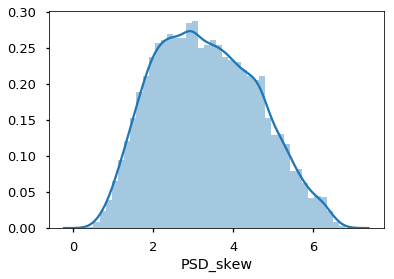

In [5]:
### ORGANIZING DATA ###
os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/')
Data = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Dataorig = Data.copy()
# remove 1020
l = [1020]

Data=Data.loc[~Data.Subject.isin(l)]
Dataorig = Data.copy()
# sanity check
sns.distplot(Data.PSD_skew)

### Bradykinesia - HP filtered features 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Bradykinesia 6949/12063 = 0.58
Training Random Forest
Subject: 1003 prec=0.629, rec=0.655, Spec=0.339, auroc_train=1.000, auroc=0.508
Subject: 1004 prec=0.379, rec=0.595, Spec=0.571, auroc_train=1.000, auroc=0.624
only 1 class in test data - cannot compute roc curve
Subject: 1005 prec=1.000, rec=0.411, Spec=nan, auroc_train=1.000, auroc=nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in long_scalars


Subject: 1007 prec=0.477, rec=0.911, Spec=0.500, auroc_train=1.000, auroc=0.830
Subject: 1009 prec=0.685, rec=0.550, Spec=0.431, auroc_train=1.000, auroc=0.471
Subject: 1016 prec=0.936, rec=0.854, Spec=0.682, auroc_train=1.000, auroc=0.790
Subject: 1018 prec=0.919, rec=0.736, Spec=0.660, auroc_train=1.000, auroc=0.719
Subject: 1019 prec=0.635, rec=0.834, Spec=0.297, auroc_train=1.000, auroc=0.574
only 1 class in test data - cannot compute roc curve
Subject: 1023 prec=1.000, rec=0.592, Spec=nan, auroc_train=1.000, auroc=nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in long_scalars


Subject: 1024 prec=0.717, rec=0.870, Spec=0.481, auroc_train=1.000, auroc=0.752
Subject: 1029 prec=0.693, rec=0.661, Spec=0.582, auroc_train=1.000, auroc=0.656
Subject: 1030 prec=0.648, rec=0.958, Spec=0.315, auroc_train=1.000, auroc=0.631
Subject: 1032 prec=0.820, rec=0.738, Spec=0.427, auroc_train=1.000, auroc=0.588
Subject: 1038 prec=0.069, rec=0.712, Spec=0.277, auroc_train=1.000, auroc=0.497
only 1 class in test data - cannot compute roc curve
Subject: 1039 prec=1.000, rec=0.610, Spec=nan, auroc_train=1.000, auroc=nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve
Subject: 1043 prec=1.000, rec=0.771, Spec=nan, auroc_train=1.000, auroc=nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in long_scalars


Subject: 1044 prec=0.076, rec=0.918, Spec=0.335, auroc_train=1.000, auroc=0.726
Subject: 1046 prec=0.563, rec=0.531, Spec=0.527, auroc_train=1.000, auroc=0.545
only 1 class in test data - cannot compute roc curve
Subject: 1048 prec=1.000, rec=0.850, Spec=nan, auroc_train=1.000, auroc=nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in long_scalars


Subject: 1049 prec=0.925, rec=0.506, Spec=0.407, auroc_train=1.000, auroc=0.450
Subject: 1051 prec=0.374, rec=0.766, Spec=0.356, auroc_train=1.000, auroc=0.668
f1_test=0.649+/-0.206, prec=0.693+/-0.284, rec=0.716+/-0.149, auprc=0.727+/-0.261, auroc=0.627+/-0.112
1003: 0.5078349150297947
1004: 0.6235114179153307
1005: nan
1049: 0.45020919507440693
1009: 0.4713405760738659
1038: 0.49747612105915884
1046: 0.5449944792050055
1019: 0.5741189240527798
1032: 0.5875119825708062
1030: 0.6306729264475743
1029: 0.6564141144091157
1051: 0.6676572990068246
1018: 0.718883581801515
1044: 0.7263518546104573
1024: 0.7517882935552652
1016: 0.7900317495951125
1007: 0.8298765432098766
1023: nan
1039: nan
1043: nan
1048: nan
Elapsed time = 0.920 min


(0.45, 1)

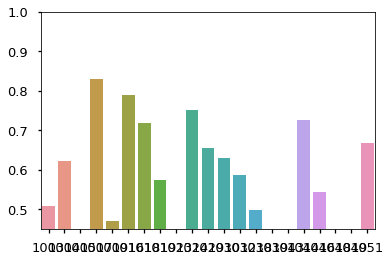

In [6]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe  ###MAKE SURE THIS IS CORRECT
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group,subj_auroc_pairings = LOSOCV(Data,X,y,groups,models)
    for key, value in sorted(subj_auroc_pairings.items(), key= lambda item : (item[1], item[0])):
        print ("%s: %s" % (key, value))
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    
sns.barplot(x=Data.Subject.unique(),y=res_group['Random Forest']['auroc'])
plt.ylim([0.45,1])

### Tremor - HP filtered features 

In [7]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Tremor']: ##changed
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group,subj_auroc_pairings = LOSOCV(Data,X,y,groups,models)
    for key, value in sorted(subj_auroc_pairings.items(), key= lambda item : (item[1], item[0])):
        print ("%s: %s" % (key, value))
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 4518/16045 = 0.28
Training Random Forest
Subject: 1003 prec=0.775, rec=0.264, Spec=0.931, auroc_train=1.000, auroc=0.687
Subject: 1004 prec=0.223, rec=0.516, Spec=0.822, auroc_train=1.000, auroc=0.692
Subject: 1005 prec=1.000, rec=0.018, Spec=1.000, auroc_train=1.000, auroc=0.420
Subject: 1007 prec=0.250, rec=0.294, Spec=0.903, auroc_train=1.000, auroc=0.690
Subject: 1009 prec=0.250, rec=0.031, Spec=0.967, auroc_train=1.000, auroc=0.423
Subject: 1016 prec=0.701, rec=0.158, Spec=0.960, auroc_train=1.000, auroc=0.727
Subject: 1018 prec=0.594, rec=0.317, Spec=0.958, auroc_train=1.000, auroc=0.854
Subject: 1019 prec=0.310, rec=0.338, Spec=0.949, auroc_train=1.000, auroc=0.762
Subject: 1023 prec=0.933, rec=0.311, Spec=0.974, auroc_train=1.000, auroc=0.803
Subject: 1024 prec=0.595, rec=0.340, Spec=0.882, auroc_train=1.000, auroc=0.728
Subject: 1029 prec=0.645, rec=0.383, Spec=0.829, auroc_train=1.000, auroc=0.735
Subject: 1030 prec=0.769, rec=0.667, Spec=0.980, auroc_train=1.00

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
Subject: 1039 prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
Subject: 1043 prec=0.455, rec=0.109, Spec=0.848, auroc_train=1.000, auroc=0.480


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
Subject: 1044 prec=0.000, rec=0.000, Spec=0.891, auroc_train=1.000, auroc=nan
Subject: 1046 prec=0.236, rec=0.067, Spec=0.844, auroc_train=1.000, auroc=0.270
only 1 class in test data - cannot compute roc curve
Subject: 1048 prec=1.000, rec=0.900, Spec=nan, auroc_train=1.000, auroc=nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in long_scalars


Subject: 1049 prec=0.951, rec=0.565, Spec=0.900, auroc_train=1.000, auroc=0.875
Subject: 1051 prec=0.000, rec=0.000, Spec=0.917, auroc_train=1.000, auroc=0.649
f1_test=0.342+/-0.260, prec=0.524+/-0.336, rec=0.303+/-0.247, auprc=0.546+/-0.283, auroc=0.697+/-0.185
1046: 0.27001301894980473
1005: 0.41982886904761907
1009: 0.4233179489350891
1043: 0.4799807374793616
1051: 0.6485155105844761
1003: 0.6871904919115219
1007: 0.6897533206831119
1004: 0.6920369459474232
1016: 0.7265007488143772
1024: 0.7280528946272384
1029: 0.7348467468658744
1019: 0.761802334879258
1023: 0.8025584795321637
1018: 0.8536898372458496
1038: 0.8668043339964253
1049: 0.8747439165701044
1032: 0.9096523786717752
1030: 0.9847494553376906
1039: nan
1044: nan
1048: nan
Elapsed time = 1.182 min


### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Training Model on Clinic Data

In [8]:
### SETUP TRAINING DATA (from clicic visits) ###

# get all data and remove useless rows
Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Xtrain = Xtrain[Xtrain.Subject!=1020]
Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]
Xtrain = Xtrain.reset_index(drop=True)
# get tremor training target
# indp = ((Xtrain['Tremor']>0))
indp = Xtrain['Tremor']
indp = indp.values
ytrain_tremor = indp.astype(int)
# get bradykinesia training target
# indp = ((Xtrain['Bradykinesia']>0))
indp = Xtrain['Bradykinesia']
indp = indp.values
ytrain_bradykinesia = indp.astype(int)
# get the training data set
Xtrain = Xtrain.iloc[:,5:].as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### Testing Model on All Home Data

In [9]:
### SETUP TEST DATA (from home data) ###

# get all data
Xtest_sets = []
test_set_info = []
test_set_info_cols = ['subj', 'date', 'MDS score']
home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features/')
# remove extra files
for name in home_feature_files:
    if "features" not in name:
        home_feature_files.remove(name)
summary_info = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study\\subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# get the testing data sets and the summary info about each testing set
for file in home_feature_files:
    user = int(file[9:15])
    date = dt.datetime.strptime(file[16:26], "%Y-%m-%d")
    try:
        MDS_score = int(summary_info.loc[(summary_info.FormDate == date) & (summary_info["6_digit_id"] == user), 'MDS_score'])
    except:
        MDS_score = float('Nan')
    Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features//' + file)
    Xtest = Xtest.iloc[:, 2:]
    # Xtest = Xtest.sample(frac = 0.2)
    num_clips = len(Xtest.index)
    test_set_info.append([user, date, MDS_score])
    Xtest_sets.append(Xtest.as_matrix())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

In [10]:
### RUN TRAINING ALGORITHM ###
df = train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols)
correlations = df.corr(method = 'pearson')
correlations.style

,subj,MDS score,tremor score,ts_var,bradykinesia score,bs_var
subj,1,-0.0723271,-0.144334,-0.173814,-0.100593,-0.102212
MDS score,-0.0723271,1,0.0583152,0.0309469,0.147634,-0.0598685
tremor score,-0.144334,0.0583152,1,0.897552,0.588445,-0.113566
ts_var,-0.173814,0.0309469,0.897552,1,0.350433,-0.0800898
bradykinesia score,-0.100593,0.147634,0.588445,0.350433,1,-0.291535
bs_var,-0.102212,-0.0598685,-0.113566,-0.0800898,-0.291535,1


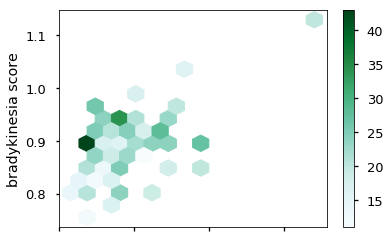

In [11]:
# predicted bradykinesia score vs tremor score where color indicates MDS score
df.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', gridsize = 15, reduce_C_function = np.mean)

In [12]:
# examine correlations for each subject
subjects = df.subj.unique()
for s in subjects:
    df1 = df[df.subj == s]
    if (len(df1.index) < 4):
        continue
    correlations = df1.corr(method = 'pearson')
    print("\n\n\nSubject " + s.__str__() + " all data correlation\n" + len(df1.index).__str__() + " samples\n")
    print(correlations.loc['MDS score', ['tremor score', 'bradykinesia score']])
    




Subject 142584 all data correlation
4 samples

tremor score         -0.892950
bradykinesia score   -0.793232
Name: MDS score, dtype: float64



Subject 142615 all data correlation
4 samples

tremor score         NaN
bradykinesia score   NaN
Name: MDS score, dtype: float64



Subject 142602 all data correlation
4 samples

tremor score         NaN
bradykinesia score   NaN
Name: MDS score, dtype: float64



Subject 142557 all data correlation
4 samples

tremor score         NaN
bradykinesia score   NaN
Name: MDS score, dtype: float64



Subject 142616 all data correlation
4 samples

tremor score         -0.804429
bradykinesia score    0.667706
Name: MDS score, dtype: float64



Subject 142593 all data correlation
4 samples

tremor score          0.677998
bradykinesia score    0.819988
Name: MDS score, dtype: float64



Subject 142583 all data correlation
4 samples

tremor score         -0.749978
bradykinesia score   -0.681232
Name: MDS score, dtype: float64



Subject 142618 all data c

### Testing Model on Home Data - Walking Only

In [13]:
### SET UP TEST DATA - Walking Only ###
# get all data
Xtest_sets = []
test_set_info = []
test_set_info_cols = ['subj', 'date', 'MDS score']

home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features + Gait/')
for name in home_feature_files:
    if "features" not in name:
        home_feature_files.remove(name)
summary_info = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study\\subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# get the testing data sets and the summary info about each testing set
for file in home_feature_files:
    user = int(file[14:20])
    date = dt.datetime.strptime(file[21:31], "%Y-%m-%d")
    trial = int(file[21:22])
    try:
        MDS_score = int(summary_info.loc[(summary_info.trial == trial) & (summary_info["6_digit_id"] == user), 'MDS_score'])
    except:
        MDS_score = float('Nan')
    Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features + Gait//' + file)
    Xtest = Xtest.loc[Xtest.Gait != 0]
    Xtest = Xtest.iloc[:, 2:-3]
    num_clips = len(Xtest.index)
    if(num_clips == 0):
        continue
    test_set_info.append([user, date, MDS_score])
    Xtest_sets.append(Xtest.as_matrix())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

In [14]:
### RUN TRAINING ALGORITHM ###
df = train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols)
correlations = df.corr(method = 'pearson')
correlations.style

,subj,MDS score,tremor score,ts_var,bradykinesia score,bs_var
subj,1,-0.40222,-0.0105676,-0.0763909,-0.0415521,0.114212
MDS score,-0.40222,1,0.189945,0.189494,-0.0939028,-0.336584
tremor score,-0.0105676,0.189945,1,0.713465,-0.124487,0.309559
ts_var,-0.0763909,0.189494,0.713465,1,-0.09999,0.0425638
bradykinesia score,-0.0415521,-0.0939028,-0.124487,-0.09999,1,-0.402187
bs_var,0.114212,-0.336584,0.309559,0.0425638,-0.402187,1


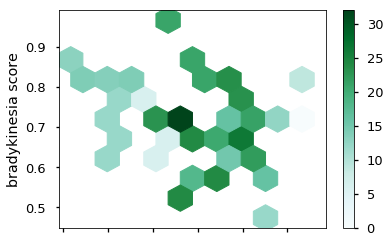

In [15]:
# predicted bradykinesia score vs predicted tremor score where color indicate MDS score
df.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', gridsize = 10, reduce_C_function = np.mean)

### Testing Model on Home Data - Non-Walking Only

In [16]:
### SET UP TEST DATA - Non-Walking Only ###
# get all data
Xtest_sets = []
test_set_info = []
test_set_info_cols = ['subj', 'date', 'MDS score']
home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features + Gait/')
# remove extra files
for name in home_feature_files:
    if "features" not in name:
        home_feature_files.remove(name)
summary_info = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study\\subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# get the testing data sets and the summary info about each testing set
for file in home_feature_files:
    user = int(file[14:20])
    date = dt.datetime.strptime(file[21:31], "%Y-%m-%d")
    try:
        MDS_score = int(summary_info.loc[(summary_info.FormDate == date) & (summary_info["6_digit_id"] == user), 'MDS_score'])
    except:
        MDS_score = float('Nan')
    Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features + Gait//' + file)
    Xtest = Xtest.loc[Xtest.Gait == 0]
    Xtest = Xtest.iloc[:, 2:-3]
    num_clips = len(Xtest.index)
    if(num_clips == 0):
        continue
    test_set_info.append([user, date, MDS_score])
    Xtest_sets.append(Xtest.as_matrix())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

In [17]:
### RUN TRAINING ALGORITHM ###
df = train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols)
correlations = df.corr(method = 'pearson')
correlations.style

,subj,MDS score,tremor score,ts_var,bradykinesia score,bs_var
subj,1,-0.0723271,-0.148271,-0.174389,-0.104299,-0.0909028
MDS score,-0.0723271,1,0.0601078,0.0343548,0.121335,-0.0569063
tremor score,-0.148271,0.0601078,1,0.898954,0.634533,-0.151111
ts_var,-0.174389,0.0343548,0.898954,1,0.373877,-0.0892962
bradykinesia score,-0.104299,0.121335,0.634533,0.373877,1,-0.33643
bs_var,-0.0909028,-0.0569063,-0.151111,-0.0892962,-0.33643,1


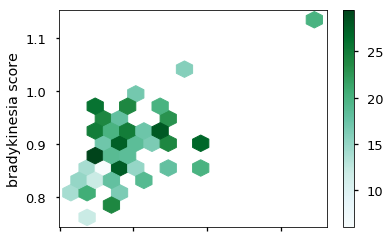

In [18]:
# predicted bradykinesia score vs predicted tremor score where color indicates MDS score
df.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', gridsize = 15, reduce_C_function = np.mean)

### Testing Model on Task Data

In [19]:
### SET UP TEST DATA ###
# get all data
Xtest_sets = []
test_set_info = []
test_set_info_cols = ['subj', 'date', 'MDS score']

task_feature_files = os.listdir('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//')

summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study//subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# get the testing data sets and the summary info about each testing set
for file in task_feature_files:
    user = int(file[0:6])
    date = dt.datetime.strptime(file[7:17], "%Y-%m-%d")
    trial = int(file[-5:-4])
    task = file[18:-6]
    if (task != 'Wlkg'):
        continue
    # optional skip sessions based on trial number
    #if (trial not in [5]):
    #    continue
    # note: scores for repeat-visits on same day may be misleading because of medication differences; are there separate MDS scores for these visits?
    try:
        MDS_score = int(summary_info.loc[(summary_info.trial == trial) & (summary_info["6_digit_id"] == user), 'MDS_score'])
    except:
        MDS_score = float('Nan')
    Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + file)
    Xtest = Xtest.iloc[:, 0:-6]
    # num_clips = len(Xtest.index)
    # if(num_clips == 0):
    #     continue
    
    test_set_info.append([user, date, MDS_score])
    Xtest_sets.append(Xtest.as_matrix())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

In [20]:
### RUN TRAINING ALGORITHM ###
df = train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols)
correlations = df.corr(method = 'pearson')
correlations.style

,subj,MDS score,tremor score,ts_var,bradykinesia score,bs_var
subj,1,-0.507354,-0.0588279,-0.148886,0.177166,-0.117896
MDS score,-0.507354,1,0.314372,0.217506,0.226705,0.259365
tremor score,-0.0588279,0.314372,1,0.367714,0.260508,0.0121172
ts_var,-0.148886,0.217506,0.367714,1,-0.0295283,0.151542
bradykinesia score,0.177166,0.226705,0.260508,-0.0295283,1,0.109054
bs_var,-0.117896,0.259365,0.0121172,0.151542,0.109054,1


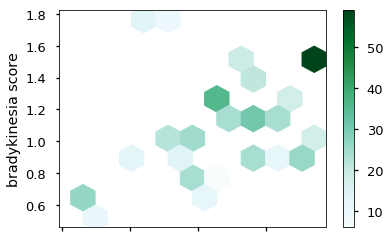

In [21]:
# predicted bradykinesia score vs predicted tremor score where color indicates MDS score
df.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', gridsize = 10)

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Training and Testing Model on Task Data

In [22]:
""" Repeatedly train a model on 80% of the task data and test it on the remaining 20%, storing the results in 
    the results list """
# set up
results = []

summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])

subjs = []
task_feature_files = os.listdir('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//')
test_set_info_cols = ['subj', 'date', 'MDS score', 'task']

# make list of subjects
for file in task_feature_files:
    s = int(file[0:6])
    if s not in subjs:
        subjs.append(s)

for c in range(5): # train and test five random models
    num_subjs = len(subjs) * 0.2        
    subjs_left_out = np.random.choice(a = subjs, size = int(num_subjs), replace = False)
    
    Xtrain = pd.DataFrame()
    Xtest_sets = []
    test_set_info = []

    for file in task_feature_files:
        s = int(file[0:6])
        features_to_add = pd.read_pickle("//FS2.smpp.local//RTO//CIS-PD Study\MJFF Curation\TaskFeatures\\" + file)
        # set up train data
        if s not in subjs_left_out:
            Xtrain = Xtrain.append(features_to_add, ignore_index = True)
        # set up test data
        else:
            date = dt.datetime.strptime(file[7:17], "%Y-%m-%d")
            task = file[18:-6]
            trial = int(file[7:8])
            try:
                MDS_score = int(summary_info.loc[(summary_info.trial == trial) & (summary_info["6_digit_id"] == s), 'MDS_score'])
            except:
                MDS_score = float('Nan')
                
            Xtest = features_to_add.iloc[:, 0:-6]
            Xtest_sets.append(Xtest.as_matrix())
            num_clips = len(Xtest.index)
            test_set_info.append([s, date, MDS_score, task])

    Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
    Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]
    Xtrain = Xtrain.reset_index(drop=True)
    # get tremor training target
    # indp = ((Xtrain['Tremor']>0)) # for classifier
    indp = Xtrain['Tremor']
    indp = indp.values
    ytrain_tremor = indp.astype(int)
    # get bradykinesia training target
    # indp = ((Xtrain['Bradykinesia']>0)) # for classifier
    indp = Xtrain['Bradykinesia']
    indp = indp.values
    ytrain_bradykinesia = indp.astype(int)
    # get the training data set
    Xtrain = Xtrain.iloc[:,0:-6].as_matrix()
    
    results.append(train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

In [23]:
""" for each task, find the mean and variance of the correlations between the MDS-UPDRS scores and the tremor score 
    and the MDS-UPDRS scores and the bradykinesia scores from all of the randomly grouped models. Print only the results
    where the mean correlation between the MDS score and the tremor or bradykinesia score is greater than 0.25 """

tasks = results[0].task.unique()
# set up dictionaries where keys are tasks and values are lists of corresponding scores
bs_task_dict = {key: [] for key in tasks}
ts_task_dict = {key: [] for key in tasks}
for df in results:
    for t in df.task.unique():
        dft = df[df.task == t]
        # print(t + ': ' + len(dft.index).__str__() + ' entries \n')
        ts_mds_corr = dft.corr(method = 'pearson').loc['MDS score']['tremor score']            
        bs_mds_corr = dft.corr(method = 'pearson').loc['MDS score']['bradykinesia score']
        bs_task_dict[t].append(bs_mds_corr)
        ts_task_dict[t].append(ts_mds_corr)

most_correlated_tasks = []
# print out the most correlated tasks (corr coef > 0.25) and their scores
for t in tasks:
    bm = np.mean(bs_task_dict[t])
    bv = np.var(bs_task_dict[t])
    tm = np.mean(ts_task_dict[t])
    tv = np.var(ts_task_dict[t])
    if ((bm >= 0.25) or (tm >= 0.25)): # print only significant results
        print('\n' + t + ' results:\n')
        most_correlated_tasks.append(t)
        if (bm >= 0.25):
            print('bradykinesia-mds | mean corr: ' + bm.__str__() + ' | var: ' + bv.__str__() + '\n' )
        if (tm >= 0.25):
            print('tremor-mds | mean corr: ' + tm.__str__() + ' | var: ' + tv.__str__() + '\n' )


Wlkg results:

bradykinesia-mds | mean corr: 0.3087943306611924 | var: 0.17265142561114138

tremor-mds | mean corr: 0.33389651980722657 | var: 0.24145789200164808


WlkgCnt results:

tremor-mds | mean corr: 0.3064766954171401 | var: 0.24944612225049007


Drnkg results:

bradykinesia-mds | mean corr: 0.26925069330223683 | var: 0.16184694063850139

tremor-mds | mean corr: 0.5051181050505873 | var: 0.05730996465661371


Stndg results:

bradykinesia-mds | mean corr: 0.29345794223831934 | var: 0.17235059705286873

tremor-mds | mean corr: 0.3130035474407677 | var: 0.1192786257809844


NtsBts results:

tremor-mds | mean corr: 0.2693436396941788 | var: 0.00520780557867777



AxesSubplot(0.125,0.125;0.62x0.755)


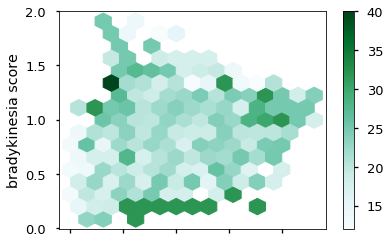

In [24]:
""" Make a hexbin plot of the model's predicted bradykinesia score vs the model's predicted Tremor Score 
    where the darkeness of the bin corresponds to the MDS_UPDRS score """

df_combined = pd.DataFrame()
for df in results:
    df_combined = df_combined.append(df, ignore_index = True)
    
print(df_combined.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', reduce_C_function = np.mean, gridsize = 15))

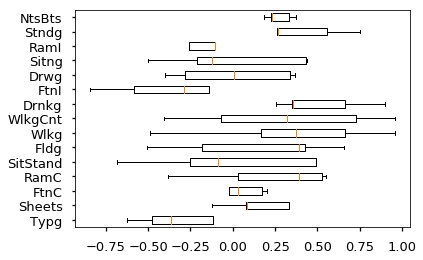

<Figure size 432x288 with 0 Axes>

In [25]:
""" for each task, make a box plot of the correlation between the MDS score and the model's predicted Tremor Score """

labels = ts_task_dict.keys()
values = []
for l in labels:
    values.append(ts_task_dict[l])
plt.boxplot(x = values, labels = labels, vert = False)
plt.figure()
plt.show()
    

AxesSubplot(0.125,0.125;0.62x0.755)


 tasks included: ['Wlkg', 'WlkgCnt', 'Drnkg', 'Stndg', 'NtsBts']


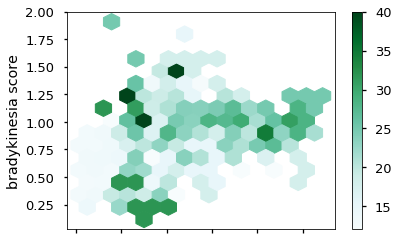

In [26]:
""" Only including the tasks that are the strongest correlated with the MDS score, make a hexbin plot of the model's 
    predicted bradykinesia score vs the model's predicted Tremor Score where the darkeness of the bin corresponds to 
    the MDS_UPDRS score """

df_combined = pd.DataFrame()
for df in results:
    df_combined = df_combined.append(df, ignore_index = True)
    
df_combined = df_combined.loc[df_combined.task.isin(most_correlated_tasks)]
    
print(df_combined.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', reduce_C_function = np.mean, gridsize = 15))
print("\n\n tasks included: " + most_correlated_tasks.__str__())

AxesSubplot(0.125,0.125;0.62x0.755)


 tasks included: ['Wlkg', 'WlkgCnt']


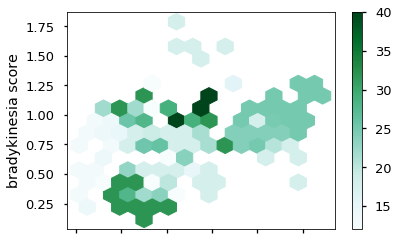

In [27]:
""" Only including walking and walking while counting tasks, make a hexbin plot of the model's 
    predicted bradykinesia score vs the model's predicted Tremor Score where the darkeness of the bin corresponds to 
    the MDS_UPDRS score """

df_combined = pd.DataFrame()
for df in results:
    df_combined = df_combined.append(df, ignore_index = True)

tasks_to_include = ['Wlkg', 'WlkgCnt']
df_combined = df_combined.loc[df_combined.task.isin(tasks_to_include)]
    
print(df_combined.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', reduce_C_function = np.mean, gridsize = 15))
print("\n\n tasks included: " + tasks_to_include.__str__())

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Training and Testing Model on Task Data - LOSOCV

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


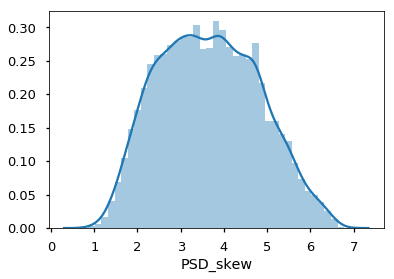

In [28]:
""" trying to determine if the same subjects fit the model poorly as in original model cross-validation, using
    auroc as a measure of how well the subject fits the model """

### organize data
task_feature_files = os.listdir('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//')
Data = pd.DataFrame()
for f in task_feature_files:
    # Exclude subjects who did not fit original models for Tremor and Bradykinesia
    # l = ['142561', '142618', '142622', '142612', '142608', '142578', '142563', '142577', '142560', '142585', '142581', '142583', '142593', '142575']
       # Exclude subjects who did not fit original model for Tremor
    # l = ['142622', '142575', '142608', '142585', '142563', '142612', '142561'] #, '142593']  # subj 1020=142561 optional at end
    l = [] # Include all subjects
    if f[:6] not in l:
        if(Data.empty):
            Data = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + f)
        else:
            d = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + f)
            Data = Data.append(d, ignore_index = True)
Data = Data[~Data['Tremor'].isnull()]
Data = Data[~Data['Bradykinesia'].isnull()]
np.sort(Data.Subject.unique())
# remove 1020
Data=Data[Data.Subject!=1020]
Dataorig = Data.copy()
# sanity check
sns.distplot(Data.PSD_skew)

In [29]:
""" Run a leave-one-subject-out cross validation for each subject on a model trained with all the other 
    subjects' task data to predict the Bradykinesia score. """

t1=time.time()
res_all = pd.DataFrame()

Data = Dataorig.copy()
Data=Data.reset_index(drop=True) #reset index


for symptom in ['Bradykinesia']:
    
    #remove nan rows for current symptom
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
        
    
    X = Data.iloc[:,0:-6].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,0:-6].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          

    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group,subj_auroc_pairings = LOSOCV(Data,X,y,groups,models)
    print("\nSorted auroc for each subject:\n")
    for key, value in sorted(subj_auroc_pairings.items(), key= lambda item : (item[1], item[0])):
        print ("%s: %s" % (key, value))
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Bradykinesia 6949/12063 = 0.58
Training Random Forest
Subject: 1003 prec=0.640, rec=0.787, Spec=0.243, auroc_train=1.000, auroc=0.525
Subject: 1004 prec=0.416, rec=0.642, Spec=0.603, auroc_train=1.000, auroc=0.680
only 1 class in test data - cannot compute roc curve
Subject: 1005 prec=1.000, rec=0.486, Spec=nan, auroc_train=1.000, auroc=nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in long_scalars


Subject: 1007 prec=0.520, rec=0.867, Spec=0.600, auroc_train=1.000, auroc=0.816
Subject: 1009 prec=0.596, rec=0.425, Spec=0.351, auroc_train=1.000, auroc=0.357
Subject: 1016 prec=0.934, rec=0.844, Spec=0.675, auroc_train=1.000, auroc=0.780
Subject: 1018 prec=0.928, rec=0.716, Spec=0.709, auroc_train=1.000, auroc=0.760
Subject: 1019 prec=0.644, rec=0.854, Spec=0.309, auroc_train=1.000, auroc=0.565
only 1 class in test data - cannot compute roc curve
Subject: 1023 prec=1.000, rec=0.672, Spec=nan, auroc_train=1.000, auroc=nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in long_scalars


Subject: 1024 prec=0.724, rec=0.844, Spec=0.513, auroc_train=1.000, auroc=0.691
Subject: 1029 prec=0.696, rec=0.641, Spec=0.601, auroc_train=1.000, auroc=0.666
Subject: 1030 prec=0.632, rec=0.944, Spec=0.278, auroc_train=1.000, auroc=0.757
Subject: 1032 prec=0.838, rec=0.810, Spec=0.447, auroc_train=1.000, auroc=0.673
Subject: 1038 prec=0.074, rec=0.712, Spec=0.327, auroc_train=1.000, auroc=0.496
only 1 class in test data - cannot compute roc curve
Subject: 1039 prec=1.000, rec=0.780, Spec=nan, auroc_train=1.000, auroc=nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve
Subject: 1043 prec=1.000, rec=0.840, Spec=nan, auroc_train=1.000, auroc=nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in long_scalars


Subject: 1044 prec=0.081, rec=0.980, Spec=0.337, auroc_train=1.000, auroc=0.781
Subject: 1046 prec=0.556, rec=0.545, Spec=0.500, auroc_train=1.000, auroc=0.521
only 1 class in test data - cannot compute roc curve
Subject: 1048 prec=1.000, rec=0.500, Spec=nan, auroc_train=1.000, auroc=nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in long_scalars


Subject: 1049 prec=0.941, rec=0.531, Spec=0.519, auroc_train=1.000, auroc=0.542
Subject: 1051 prec=0.422, rec=0.717, Spec=0.507, auroc_train=1.000, auroc=0.654
f1_test=0.656+/-0.205, prec=0.697+/-0.280, rec=0.721+/-0.153, auprc=0.725+/-0.258, auroc=0.641+/-0.124

Sorted auroc for each subject:

1003: 0.5251820790112558
1004: 0.6800693581103187
1005: nan
1009: 0.3565648835808913
1038: 0.49624681795435266
1046: 0.5208837215416162
1049: 0.5418865592164694
1019: 0.5645839693361826
1051: 0.6535572601675637
1029: 0.6655516731120755
1032: 0.6725795206971676
1024: 0.6906527271476718
1030: 0.757303077725613
1018: 0.7596854344574708
1016: 0.7795607972676106
1044: 0.7807736233179403
1007: 0.8156790123456791
1023: nan
1039: nan
1043: nan
1048: nan
Elapsed time = 0.975 min


In [30]:
""" Run a leave-one-subject-out cross validation for each subject on a model trained with all the other 
    subjects' task data to predict the Tremor score. """

t1=time.time()
res_all = pd.DataFrame()

Data = Dataorig.copy()
Data=Data.reset_index(drop=True) #reset index

for symptom in ['Tremor']:
    
    #remove nan rows for current symptom
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,0:-6].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,0:-6].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          

    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group,subj_auroc_pairings = LOSOCV(Data,X,y,groups,models)
    print("\nSorted auroc for each subject:\n")
    for key, value in sorted(subj_auroc_pairings.items(), key= lambda item : (item[1], item[0])):
        print ("%s: %s" % (key, value))
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))   

Rows w Tremor 3851/12063 = 0.32
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 1003 prec=0.614, rec=0.170, Spec=0.889, auroc_train=1.000, auroc=0.514
Subject: 1004 prec=0.261, rec=0.368, Spec=0.851, auroc_train=1.000, auroc=0.711
only 1 class in test data - cannot compute roc curve
Subject: 1005 prec=1.000, rec=0.028, Spec=nan, auroc_train=1.000, auroc=nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in long_scalars


Subject: 1007 prec=0.231, rec=0.176, Spec=0.915, auroc_train=1.000, auroc=0.665
Subject: 1009 prec=0.080, rec=0.058, Spec=0.805, auroc_train=1.000, auroc=0.262
Subject: 1016 prec=0.641, rec=0.177, Spec=0.911, auroc_train=1.000, auroc=0.598
Subject: 1018 prec=0.442, rec=0.243, Spec=0.916, auroc_train=1.000, auroc=0.762
Subject: 1019 prec=0.245, rec=0.667, Spec=0.892, auroc_train=1.000, auroc=0.901
Subject: 1023 prec=0.923, rec=0.143, Spec=0.976, auroc_train=1.000, auroc=0.605
Subject: 1024 prec=0.529, rec=0.347, Spec=0.765, auroc_train=1.000, auroc=0.594
Subject: 1029 prec=0.596, rec=0.257, Spec=0.822, auroc_train=1.000, auroc=0.649
Subject: 1030 prec=0.400, rec=0.267, Spec=0.945, auroc_train=1.000, auroc=0.778
Subject: 1032 prec=0.177, rec=0.528, Spec=0.837, auroc_train=1.000, auroc=0.795
Subject: 1038 prec=0.669, rec=0.175, Spec=0.809, auroc_train=1.000, auroc=0.537


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
Subject: 1039 prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
Subject: 1043 prec=0.519, rec=0.173, Spec=0.740, auroc_train=1.000, auroc=0.445


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
Subject: 1044 prec=0.000, rec=0.000, Spec=0.716, auroc_train=1.000, auroc=nan
Subject: 1046 prec=0.061, rec=0.025, Spec=0.789, auroc_train=1.000, auroc=0.213


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in long_scalars
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


only 1 class in test data - cannot compute roc curve
Subject: 1048 prec=0.000, rec=0.000, Spec=nan, auroc_train=1.000, auroc=nan
Subject: 1049 prec=0.957, rec=0.265, Spec=0.951, auroc_train=1.000, auroc=0.824
Subject: 1051 prec=0.046, rec=0.571, Spec=0.896, auroc_train=1.000, auroc=0.759
f1_test=0.216+/-0.139, prec=0.400+/-0.319, rec=0.221+/-0.186, auprc=0.508+/-0.277, auroc=0.624+/-0.183

Sorted auroc for each subject:

1003: 0.5140584535701073
1004: 0.7106135066582118
1005: nan
1046: 0.21250493096646944
1009: 0.26164691925106853
1043: 0.4445679012345679
1038: 0.5370050095419847
1024: 0.593901472937954
1016: 0.5979233723558924
1023: 0.6048199767711963
1029: 0.6485510011447392
1007: 0.6652542372881356
1051: 0.7591299677765844
1018: 0.7624785317652858
1030: 0.7781818181818182
1032: 0.794648353339489
1019: 0.9014563274321012
1039: nan
1044: nan
1048: nan
1049: 0.8238624864307924
Elapsed time = 0.906 min


### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Training Model on Walking & Walking+Counting Task Data

In [31]:
""" train a model to predict the tremor score on the data from the walking and walking while counting tasks """

t1=time.time()

# Training Model
Data = Dataorig.copy()
Data=Data.reset_index(drop=True) #reset index
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
Data=Data.reset_index(drop=True)
# update for consistency with other data
for index, row in Data.iterrows():
    if (row['Visit'] == '4 Weeks'):
        Data.loc[index, 'Visit'] = '1 Month'
Data=Data.reset_index(drop=True)
Data.head()

for index, row in Data.iterrows(): 
    try:
        Data.loc[index, 'MDS score'] = int(summary_info.loc[(summary_info.VisitNm == row['Visit']) & (summary_info["SubjectCode"] == row['Subject']), 'MDS_score'])
    except:
        Data.loc[index, 'MDS score'] = float('Nan')
        
#remove nan rows 
Data=Data[~Data['MDS score'].isnull()]
# select only walking related rows
Data=Data[(Data.Task == 'Wlkg') | (Data.Task == 'WlkgCnt')]
Data=Data.reset_index(drop=True) #reset index
Data.head()
Data.Tremor.unique()

Xtrain = Data.iloc[:,0:-7].as_matrix()

indp = Data['Tremor']
indp = indp.values
ytrain = indp.astype(int) #target 
    
clf = RandomForestRegressor(n_estimators=50,random_state=2)
clf.fit(Xtrain, ytrain)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [32]:
""" test the model on the home walking data """

# Testing Model
results = [] 
# get all data
home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features + Gait/')
for name in home_feature_files:
    if "features" not in name:
        home_feature_files.remove(name)
summary_info = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study\\subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# get the testing data sets and the summary info about each testing set
for file in home_feature_files:
    user = int(file[14:20])
    date = dt.datetime.strptime(file[21:31], "%Y-%m-%d")
    trial = int(file[21:22])
    MDS_score = 0
    try:
        MDS_score = int(summary_info.loc[(summary_info.FormDate == date) & (summary_info["6_digit_id"] == user), 'MDS_score'])
    except:
        MDS_score = float('Nan')
    Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features + Gait//' + file)
    Xtest = Xtest.loc[Xtest.Gait != 0]
    Xtest = Xtest.iloc[:, 2:-3]

    if(Xtest.empty):
        continue
    
    Xtest = Xtest.as_matrix()

    y_pred = clf.predict(Xtest)
    y = y_pred.mean()
    results.append([MDS_score, y])

results = pd.DataFrame(data = results, columns = ['MDS score', 'predicted tremor score'])


    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

Elapsed time = 0.555 min


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [33]:
results.corr(method = 'pearson')

,MDS score,predicted tremor score
MDS score,1.000000,0.113043
predicted tremor score,0.113043,1.000000


### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Training  Model on Walking & Walking+Counting Task Data directly predicting MDS score

In [34]:
""" Train a model to directly predict the MDS score on the walking and walking while counting data """

t1=time.time()

# Training Model
Data = Dataorig.copy()
Data=Data.reset_index(drop=True) #reset index
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
Data=Data.reset_index(drop=True)
for index, row in Data.iterrows():
    if (row['Visit'] == '4 Weeks'):
        Data.loc[index, 'Visit'] = '1 Month'
Data=Data.reset_index(drop=True)
Data.head()

for index, row in Data.iterrows(): 
    try:
        Data.loc[index, 'MDS score'] = int(summary_info.loc[(summary_info.VisitNm == row['Visit']) & (summary_info["SubjectCode"] == row['Subject']), 'MDS_score'])
    except:
        Data.loc[index, 'MDS score'] = float('Nan')
        
#remove nan rows 
Data=Data[~Data['MDS score'].isnull()]
Data=Data[(Data.Task == 'Wlkg') | (Data.Task == 'WlkgCnt')]
Data=Data.reset_index(drop=True) #reset index

Xtrain = Data.iloc[:,0:-7].as_matrix()
indp = Data['MDS score']
indp = indp.values
ytrain = indp.astype(int) #target 
    
clf = RandomForestRegressor(n_estimators=50,random_state=2)
clf.fit(Xtrain, ytrain)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [35]:
""" test the model on the home walking data """

# Testing Model
results = [] 
# get all data
home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features + Gait/')
for name in home_feature_files:
    if "features" not in name:
        home_feature_files.remove(name)
summary_info = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study\\subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# get the testing data sets and the summary info about each testing set
for file in home_feature_files:
    user = int(file[14:20])
    date = dt.datetime.strptime(file[21:31], "%Y-%m-%d")
    trial = int(file[21:22])
    MDS_score = 0
    try:
        MDS_score = int(summary_info.loc[(summary_info.FormDate == date) & (summary_info["6_digit_id"] == user), 'MDS_score'])
    except:
        MDS_score = float('Nan')
    Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features + Gait//' + file)
    Xtest = Xtest.loc[Xtest.Gait != 0]
    Xtest = Xtest.iloc[:, 2:-3]
    if(Xtest.empty):
        continue
    Xtest = Xtest.as_matrix()
    y_pred = clf.predict(Xtest)
    y = y_pred.min() # generally probides better results than .mean(), .max() has strong negative corr indicating over estimating
    results.append([MDS_score, y])

results = pd.DataFrame(data = results, columns = ['MDS score', 'predicted y'])  
print('Elapsed time = %.3f min'%((time.time()-t1)/60))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

Elapsed time = 0.560 min


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [36]:
results.corr(method = 'pearson')

,MDS score,predicted y
MDS score,1.000000,0.246765
predicted y,0.246765,1.000000


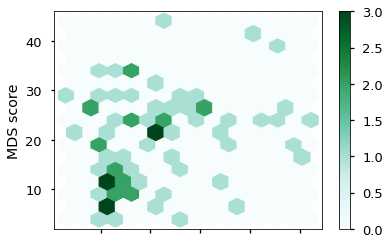

In [37]:
results.plot.hexbin(x = 'predicted y', y = 'MDS score', gridsize = 15)

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Train Personal Models for each Subject on Task Data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142592
mean squared error tremor: 0.09959044368600682
corr coef tremor predicted vs known: 0.7817087641540458
mean squared error bradykinesia: 0.056608873720136524
corr coef bradykinesia predicted vs known: 0.8342330130866483


Subject: 142592 predicted tremor vs actual tremor



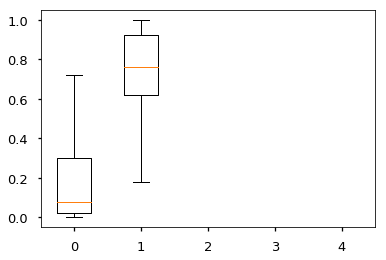

Subject: 142592 predicted bradykinesia vs actual bradykinesia



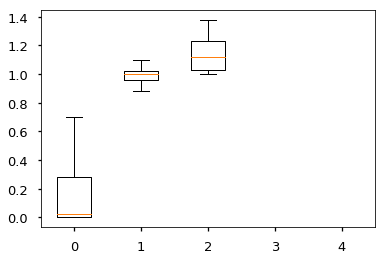

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142581
mean squared error tremor: 0.01337872340425532
corr coef tremor predicted vs known: 0.8746676253605298
mean squared error bradykinesia: 0.14865531914893615
corr coef bradykinesia predicted vs known: 0.7025700082507927


Subject: 142581 predicted tremor vs actual tremor



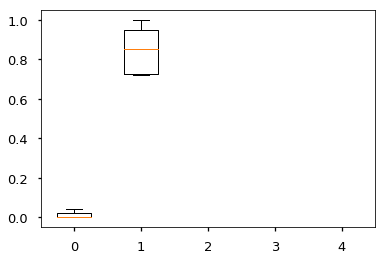

Subject: 142581 predicted bradykinesia vs actual bradykinesia



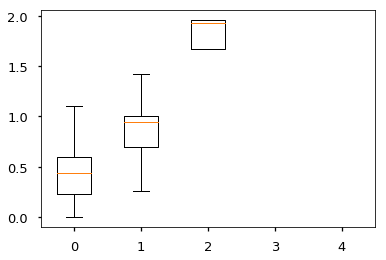

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142560
mean squared error tremor: 0.20948510638297874
corr coef tremor predicted vs known: 0.665767742635147
mean squared error bradykinesia: 0.9222340425531913
corr coef bradykinesia predicted vs known: 0.5367015326624925


Subject: 142560 predicted tremor vs actual tremor



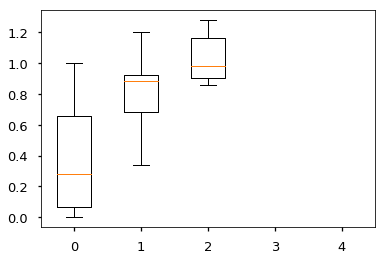

Subject: 142560 predicted bradykinesia vs actual bradykinesia



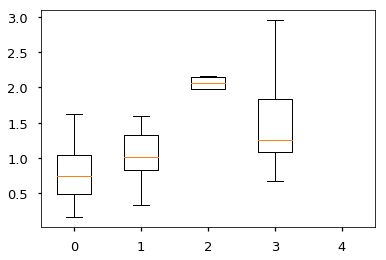

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142594
mean squared error tremor: 0.32890085470085473
corr coef tremor predicted vs known: 0.5399320128236247
mean squared error bradykinesia: 0.31317777777777783
corr coef bradykinesia predicted vs known: 0.7193312066330585


Subject: 142594 predicted tremor vs actual tremor



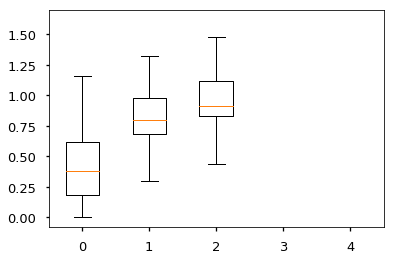

Subject: 142594 predicted bradykinesia vs actual bradykinesia



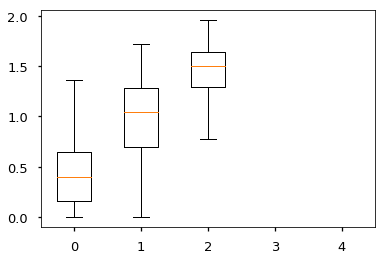

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142583
mean squared error tremor: 0.02470867052023121
corr coef tremor predicted vs known: 0.7969708673595931
mean squared error bradykinesia: 0.26169132947976875
corr coef bradykinesia predicted vs known: 0.8123525955110794


Subject: 142583 predicted tremor vs actual tremor



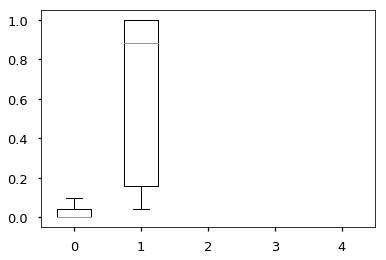

Subject: 142583 predicted bradykinesia vs actual bradykinesia



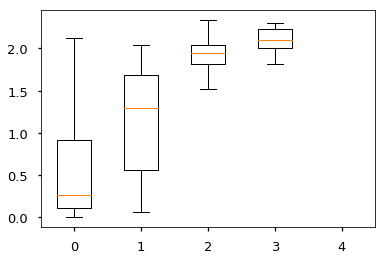

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142618
mean squared error tremor: 0.18941052631578947
corr coef tremor predicted vs known: 0.804458263069357
mean squared error bradykinesia: 0.06088421052631577
corr coef bradykinesia predicted vs known: 0.9431129953934518


Subject: 142618 predicted tremor vs actual tremor



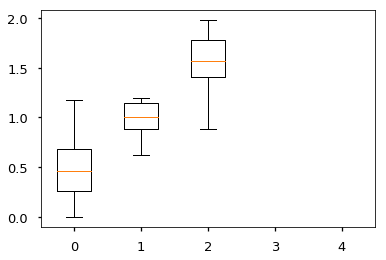

Subject: 142618 predicted bradykinesia vs actual bradykinesia



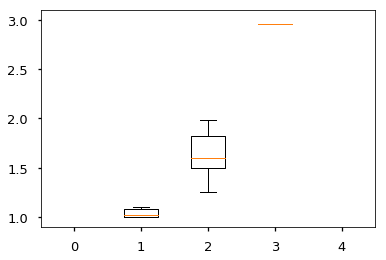

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142622
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.024300000000000006
corr coef bradykinesia predicted vs known: 0.9578484621657491


Subject: 142622 predicted tremor vs actual tremor



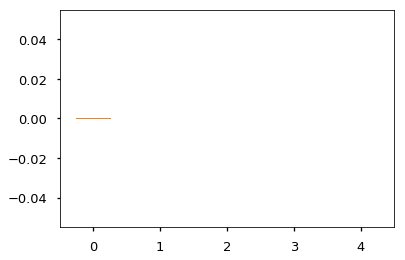

Subject: 142622 predicted bradykinesia vs actual bradykinesia



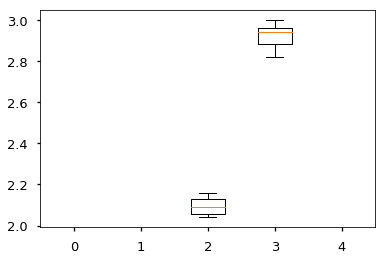

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142584
mean squared error tremor: 0.0020909090909090903
corr coef tremor predicted vs known: 0.7063836538617688
mean squared error bradykinesia: 0.16827933884297522
corr coef bradykinesia predicted vs known: 0.6766184014313559


Subject: 142584 predicted tremor vs actual tremor



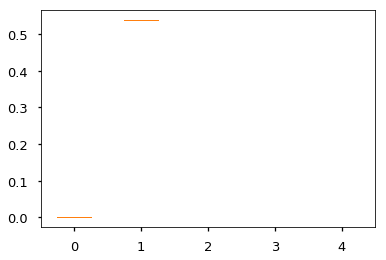

Subject: 142584 predicted bradykinesia vs actual bradykinesia



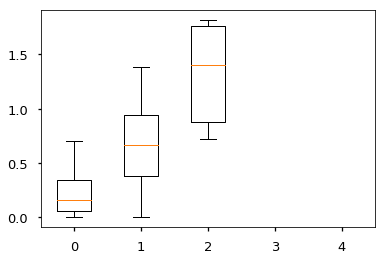

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142575
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.04393869731800766
corr coef bradykinesia predicted vs known: 0.4909234452273799


Subject: 142575 predicted tremor vs actual tremor



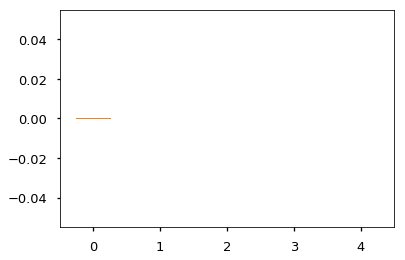

Subject: 142575 predicted bradykinesia vs actual bradykinesia



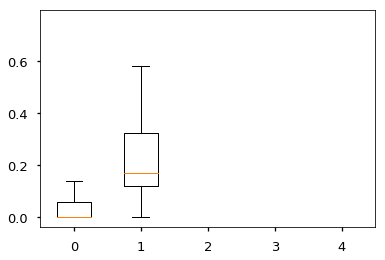

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142577
mean squared error tremor: 0.375803984063745
corr coef tremor predicted vs known: 0.839437312047529
mean squared error bradykinesia: 0.05426454183266932
corr coef bradykinesia predicted vs known: 0.31613639122822385


Subject: 142577 predicted tremor vs actual tremor



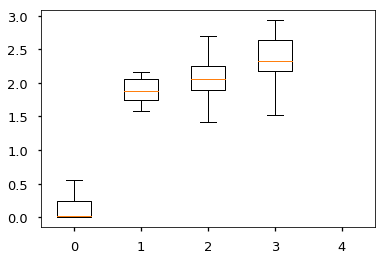

Subject: 142577 predicted bradykinesia vs actual bradykinesia



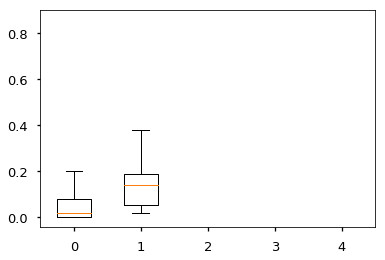

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142582
mean squared error tremor: 0.27001471571906355
corr coef tremor predicted vs known: 0.6351966709966216
mean squared error bradykinesia: 0.40138729096989967
corr coef bradykinesia predicted vs known: 0.5109707884262854


Subject: 142582 predicted tremor vs actual tremor



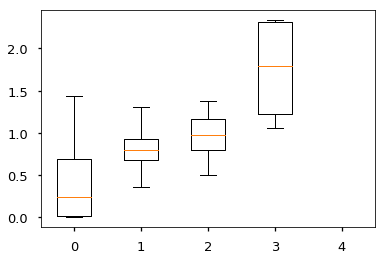

Subject: 142582 predicted bradykinesia vs actual bradykinesia



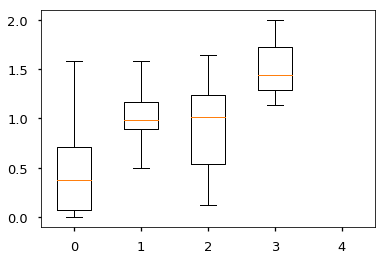

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142580
mean squared error tremor: 0.104
corr coef tremor predicted vs known: 0.6165665055609638
mean squared error bradykinesia: 0.100719391634981
corr coef bradykinesia predicted vs known: 0.7912425849307779


Subject: 142580 predicted tremor vs actual tremor



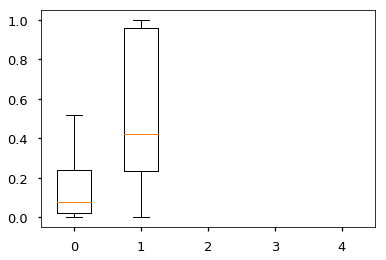

Subject: 142580 predicted bradykinesia vs actual bradykinesia



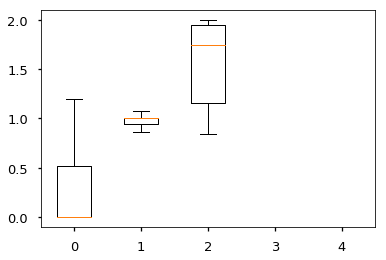

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142612
mean squared error tremor: 0.1214974358974359
corr coef tremor predicted vs known: 0.7763577753609335
mean squared error bradykinesia: 0.0
corr coef bradykinesia predicted vs known: nan


Subject: 142612 predicted tremor vs actual tremor



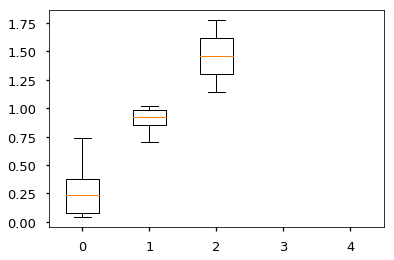

Subject: 142612 predicted bradykinesia vs actual bradykinesia



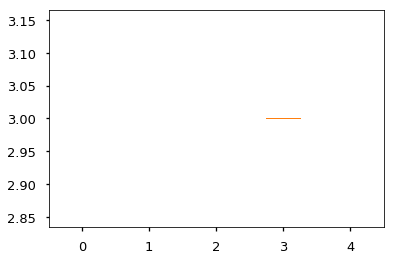

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142563
mean squared error tremor: 0.2420260869565217
corr coef tremor predicted vs known: 0.6116558474990189
mean squared error bradykinesia: 0.1452695652173913
corr coef bradykinesia predicted vs known: 0.5982743933297866


Subject: 142563 predicted tremor vs actual tremor



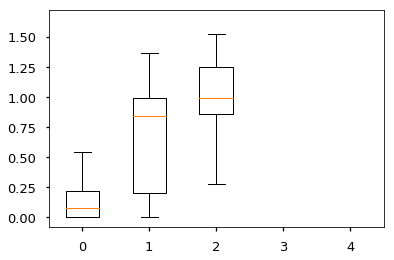

Subject: 142563 predicted bradykinesia vs actual bradykinesia



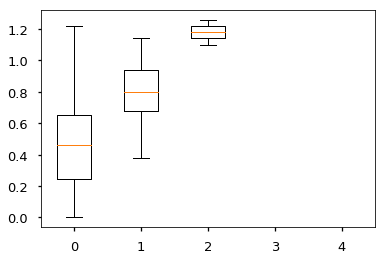

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142579
mean squared error tremor: 0.08433157894736841
corr coef tremor predicted vs known: 0.27440102534416294
mean squared error bradykinesia: 0.23856491228070173
corr coef bradykinesia predicted vs known: 0.5855617490334446


Subject: 142579 predicted tremor vs actual tremor



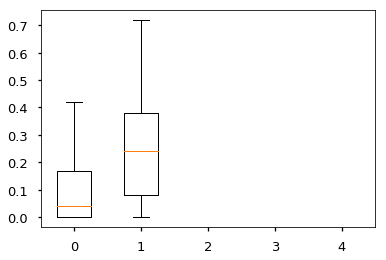

Subject: 142579 predicted bradykinesia vs actual bradykinesia



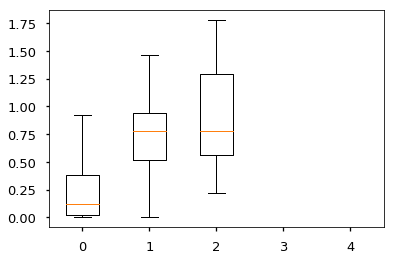

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142578
mean squared error tremor: 0.35893280000000005
corr coef tremor predicted vs known: 0.6883336240441089
mean squared error bradykinesia: 0.13316160000000002
corr coef bradykinesia predicted vs known: 0.6974664102350647


Subject: 142578 predicted tremor vs actual tremor



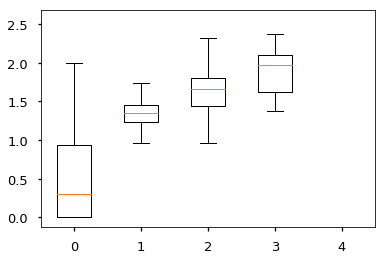

Subject: 142578 predicted bradykinesia vs actual bradykinesia



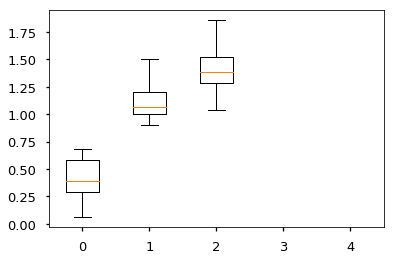

Subject: 142595
mean squared error tremor: 0.10481052631578948
corr coef tremor predicted vs known: 0.21087740805778235
mean squared error bradykinesia: 0.27699999999999997
corr coef bradykinesia predicted vs known: 0.8646170276196802


Subject: 142595 predicted tremor vs actual tremor



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


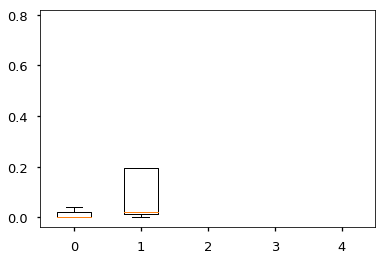

Subject: 142595 predicted bradykinesia vs actual bradykinesia



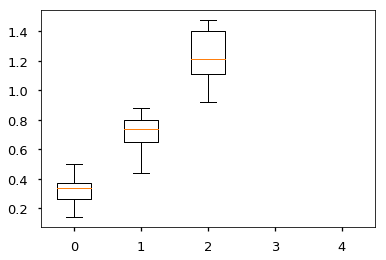

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142562
mean squared error tremor: 0.09237
corr coef tremor predicted vs known: 0.17773748188001068
mean squared error bradykinesia: 0.053649999999999996
corr coef bradykinesia predicted vs known: 0.9280015239394837


Subject: 142562 predicted tremor vs actual tremor



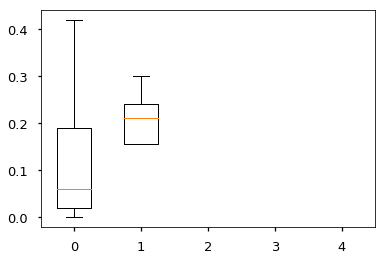

Subject: 142562 predicted bradykinesia vs actual bradykinesia



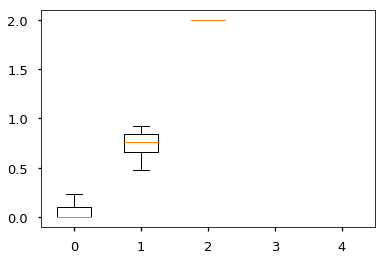

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142585
mean squared error tremor: 0.1070859574468085
corr coef tremor predicted vs known: 0.9279212036515693
mean squared error bradykinesia: 0.12288170212765956
corr coef bradykinesia predicted vs known: 0.906899125636212


Subject: 142585 predicted tremor vs actual tremor



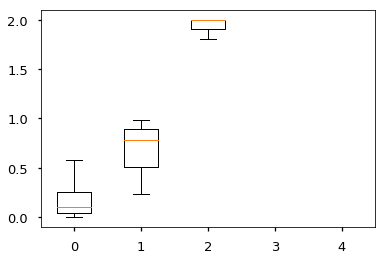

Subject: 142585 predicted bradykinesia vs actual bradykinesia



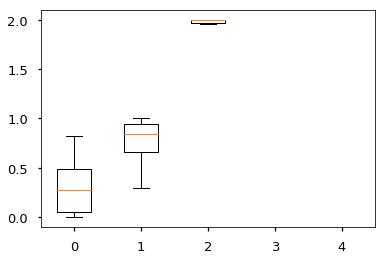

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142608
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.14373333333333335
corr coef bradykinesia predicted vs known: 0.9603095926396396


Subject: 142608 predicted tremor vs actual tremor



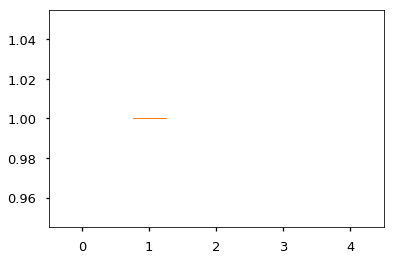

Subject: 142608 predicted bradykinesia vs actual bradykinesia



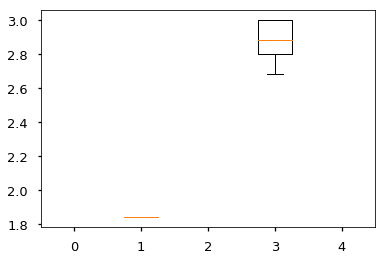

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142561
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.0
corr coef bradykinesia predicted vs known: nan


Subject: 142561 predicted tremor vs actual tremor



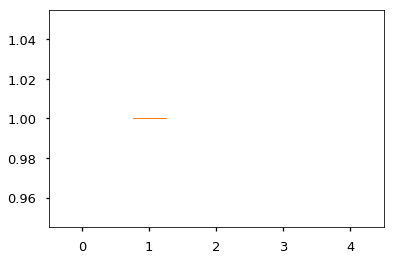

Subject: 142561 predicted bradykinesia vs actual bradykinesia



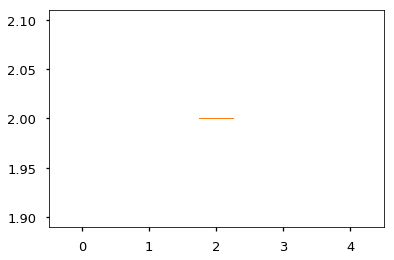

In [38]:
# set up
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])

subjs = []
task_feature_files = os.listdir('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//')
test_set_info_cols = ['subj', 'date', 'MDS score', 'task']
# get list of subjects
for file in task_feature_files:
    s = int(file[0:6])
    if s not in subjs:
        subjs.append(s)
        
# set up dictionaries where keys are subjects and values are corresponding task data files
subj_file_dict = {key: [] for key in subjs}
subj_trial_dict = {key:[] for key in subjs}
for file in task_feature_files:
    s = int(file[0:6])
    subj_file_dict[s].append(file)
    t = int(file[-5:-4])
    if t not in subj_trial_dict[s]:\
        subj_trial_dict[s].append(t)
    
# train a personal model for each subject
for s in subjs:
    files = subj_file_dict[s]
    trials = subj_trial_dict[s]
    Data = pd.DataFrame()
    for f in files:
        Data = Data.append(pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + f), ignore_index = True)
    Data = Data[~Data['Tremor'].isnull()]
    Data = Data[~Data['Bradykinesia'].isnull()]
    # Data = Data[(Data.Task == 'Wlkg') | (Data.Task == 'WlkgCnt')] # optional only include walking data
    # remove 1020
    Data=Data[Data.Subject!=1020]
    Dataorig = Data.copy()
    
    # visits = ['4 Weeks', '2 Weeks: Time 90', '2 Weeks: Time 0', '2 Weeks: Time 150', '2 Weeks: Time 60', '2 Weeks: Time 30',
    #          '2 Weeks: Time 120']
    # if (len(visits)<2):
    #     continue
    # visit_left_out = ['4 Weeks', '2 Weeks: Time 60']# np.random.choice(a = visits, size = 1, replace = False)
    # Xtest = Data[Data.Visit.isin(visit_left_out)]
    # Xtrain = Data[~Data.Visit.isin(visit_left_out)]
    
    # split randomly into testing and training groups
    num = len(Data.index.values)
    if (num < 10):
        continue
    Xtest = Data.sample(frac = 0.3)
    indices_to_exclude = Xtest.index.values
    Xtrain = Data[~Data.index.isin(indices_to_exclude)]

    if (Xtest.empty or Xtrain.empty):
        continue
    # organize data
    ytrain_tremor = Xtrain['Tremor'].values
    ytrain_bradykinesia = Xtrain['Bradykinesia'].values

    ytest_tremor = Xtest['Tremor'].values
    ytest_bradykinesia = Xtest['Bradykinesia'].values
    
    Xtrain = Xtrain.iloc[:,0:-6].as_matrix()
    Xtest = Xtest.iloc[:, 0:-6].as_matrix()

    clf = RandomForestRegressor(n_estimators=50,random_state=2)
    
    clf.fit(Xtrain, ytrain_tremor)
    ypred_t = clf.predict(Xtest)
    t_error = []
    for i in range(len(ypred_t)):
        t_error.append(math.pow(ytest_tremor[i] - ypred_t[i], 2))
    mean_squared_error_t = np.mean(t_error)
    corr_t = np.corrcoef(ytest_tremor, ypred_t)[0][1]
    
    clf.fit(Xtrain, ytrain_bradykinesia)
    ypred_b = clf.predict(Xtest)
    # ypred_b = [int(round(y, 0)) for y in ypred_b]
    b_error = []
    for i in range(len(ypred_b)):
        b_error.append(math.pow(ytest_bradykinesia[i] - ypred_b[i], 2))
    mean_squared_error_b = np.mean(b_error)
    corr_b = np.corrcoef(ytest_bradykinesia, ypred_b)[0][1]
    
    print("Subject: " + s.__str__() + "\nmean squared error tremor: " + mean_squared_error_t.__str__() + 
          "\ncorr coef tremor predicted vs known: " + corr_t.__str__() +
          "\nmean squared error bradykinesia: " + mean_squared_error_b.__str__() + 
          "\ncorr coef bradykinesia predicted vs known: " + corr_b.__str__() + "\n\n")
    
    # plot distributions of predicted scores by action scores
    t_predictions = [[],[],[],[],[]]
    b_predictions = [[],[],[],[],[]]
    for i in range(len(ypred_b)):
        t = int(ytest_tremor[i])
        b = int(ytest_bradykinesia[i])
        t_predictions[t].append(ypred_t[i])
        b_predictions[b].append(ypred_b[i])

    print('Subject: ' + s.__str__() + ' predicted tremor vs actual tremor\n')
    plt.boxplot(x = t_predictions, labels = ['0', '1', '2', '3', '4'])
    plt.show()
    
    print('Subject: ' + s.__str__() + ' predicted bradykinesia vs actual bradykinesia\n')
    plt.boxplot(x = b_predictions, labels = ['0', '1', '2', '3', '4'])
    plt.show()
        
    
    

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Train Personal Models for Each Subject on All Clinic Data

In [39]:
# get the 6 digit user_id from the corresponding 4 digit user_id
def user_id_4_to_6(user_id_4):
    for index, row in user_id_pairings.iterrows():
        if (row['SubjectCode']==user_id_4):
            if (not np.isnan(row['Subj ID Athena'])):
                return int(row['Subj ID Athena'])
            else:
                return None
    return None

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142560
mean squared error tremor: 0.40471666666666667
corr coef tremor predicted vs known: 0.38264665696696953
mean squared error bradykinesia: 1.487148717948718
corr coef bradykinesia predicted vs known: 0.224510113201088


Subject: 142560 predicted tremor vs actual tremor



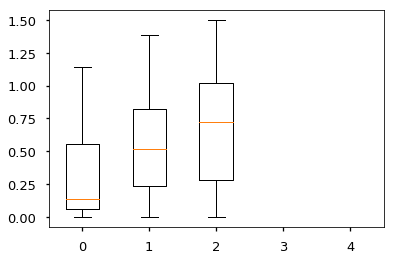

Subject: 142560 predicted bradykinesia vs actual bradykinesia



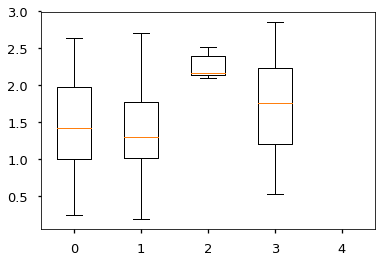

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142579
mean squared error tremor: 0.1211156785243742
corr coef tremor predicted vs known: 0.3764434976647605
mean squared error bradykinesia: 0.49614861660079057
corr coef bradykinesia predicted vs known: 0.2788882176284389


Subject: 142579 predicted tremor vs actual tremor



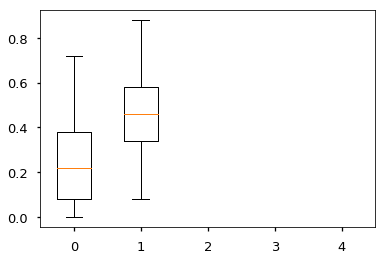

Subject: 142579 predicted bradykinesia vs actual bradykinesia



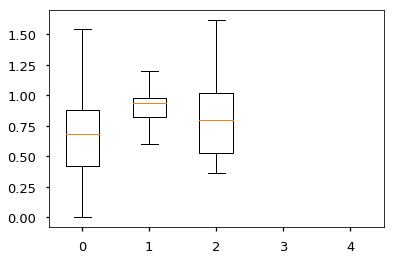

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142561
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.0
corr coef bradykinesia predicted vs known: nan


Subject: 142561 predicted tremor vs actual tremor



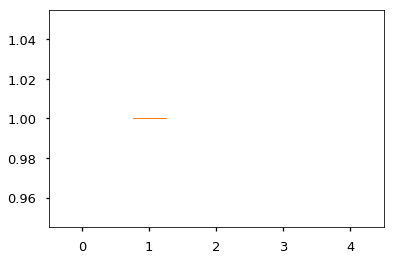

Subject: 142561 predicted bradykinesia vs actual bradykinesia



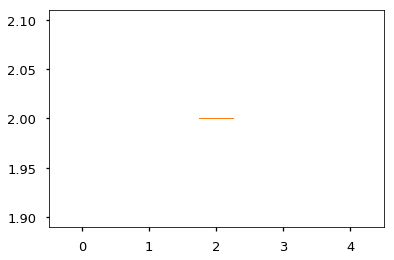

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142562
mean squared error tremor: 0.11064592592592593
corr coef tremor predicted vs known: 0.3730898814010703
mean squared error bradykinesia: 0.22140444444444446
corr coef bradykinesia predicted vs known: 0.7380072515626365


Subject: 142562 predicted tremor vs actual tremor



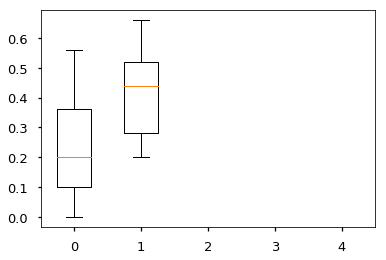

Subject: 142562 predicted bradykinesia vs actual bradykinesia



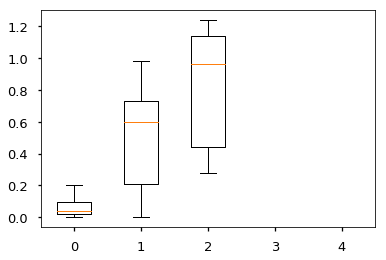

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142563
mean squared error tremor: 0.2979862745098039
corr coef tremor predicted vs known: 0.5897029882999564
mean squared error bradykinesia: 0.21928169934640523
corr coef bradykinesia predicted vs known: 0.45225156866622823


Subject: 142563 predicted tremor vs actual tremor



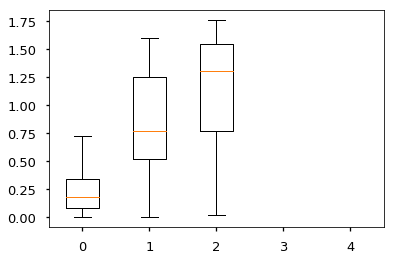

Subject: 142563 predicted bradykinesia vs actual bradykinesia



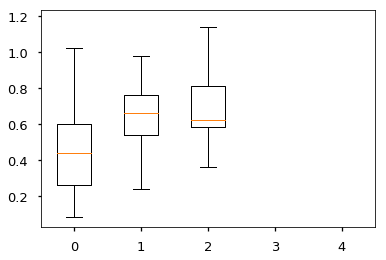

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142592
mean squared error tremor: 0.19263828045035825
corr coef tremor predicted vs known: 0.4778239414967222
mean squared error bradykinesia: 0.11970931422722621
corr coef bradykinesia predicted vs known: 0.5471500881423578


Subject: 142592 predicted tremor vs actual tremor



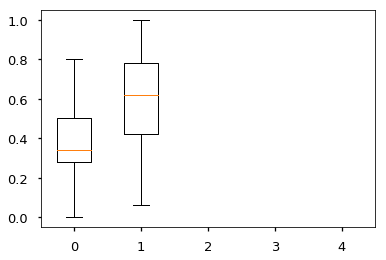

Subject: 142592 predicted bradykinesia vs actual bradykinesia



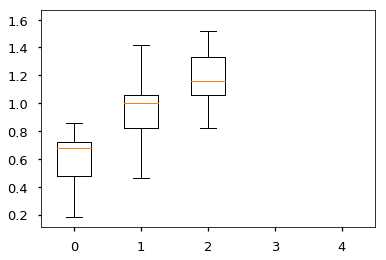

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142580
mean squared error tremor: 0.12257260273972603
corr coef tremor predicted vs known: 0.5649948609889588
mean squared error bradykinesia: 0.30802602739726026
corr coef bradykinesia predicted vs known: 0.4213564698520037


Subject: 142580 predicted tremor vs actual tremor



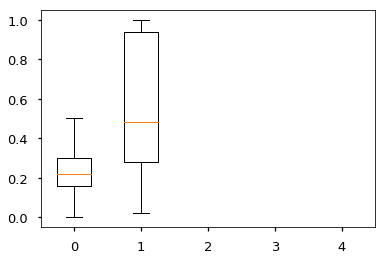

Subject: 142580 predicted bradykinesia vs actual bradykinesia



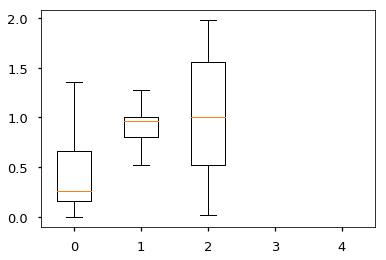

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142581
mean squared error tremor: 0.02235652173913043
corr coef tremor predicted vs known: 0.7313222649600535
mean squared error bradykinesia: 0.24646649616368288
corr coef bradykinesia predicted vs known: 0.4500676359940071


Subject: 142581 predicted tremor vs actual tremor



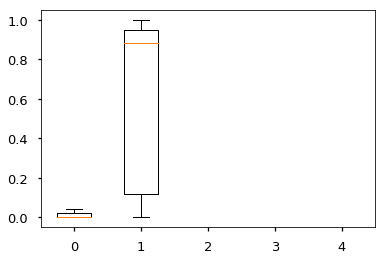

Subject: 142581 predicted bradykinesia vs actual bradykinesia



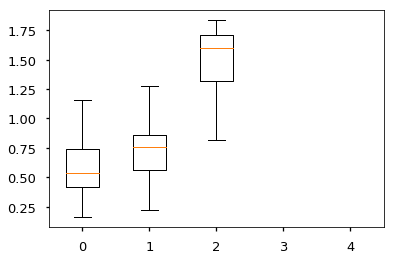

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142618
mean squared error tremor: 0.5776416
corr coef tremor predicted vs known: 0.329182557311337
mean squared error bradykinesia: 0.27759359999999994
corr coef bradykinesia predicted vs known: 0.6705372862787188


Subject: 142618 predicted tremor vs actual tremor



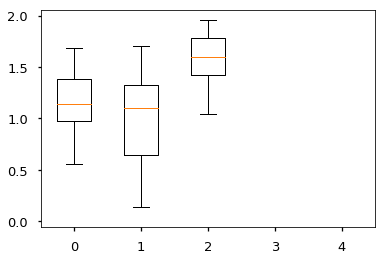

Subject: 142618 predicted bradykinesia vs actual bradykinesia



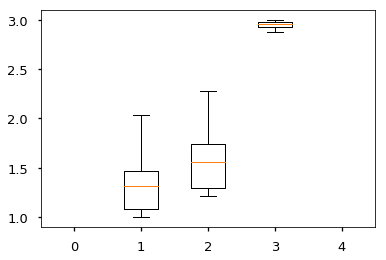

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142594
mean squared error tremor: 0.4169987163029525
corr coef tremor predicted vs known: 0.3622676916821726
mean squared error bradykinesia: 0.4027435173299101
corr coef bradykinesia predicted vs known: 0.5849129357204095


Subject: 142594 predicted tremor vs actual tremor



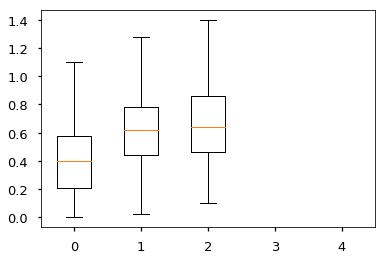

Subject: 142594 predicted bradykinesia vs actual bradykinesia



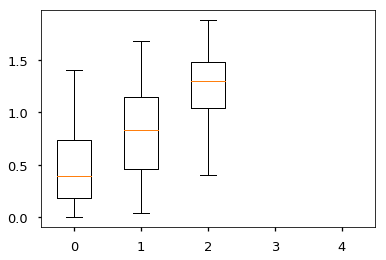

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142582
mean squared error tremor: 0.4706328657314629
corr coef tremor predicted vs known: 0.24537302068869885
mean squared error bradykinesia: 0.5197366733466935
corr coef bradykinesia predicted vs known: 0.2998800563676012


Subject: 142582 predicted tremor vs actual tremor



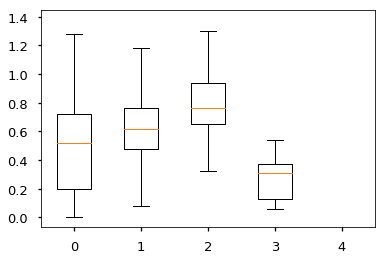

Subject: 142582 predicted bradykinesia vs actual bradykinesia



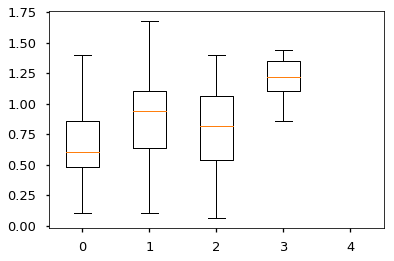

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142595
mean squared error tremor: 0.06357120000000001
corr coef tremor predicted vs known: 0.6793943106363967
mean squared error bradykinesia: 0.31699839999999996
corr coef bradykinesia predicted vs known: 0.6753621579201747


Subject: 142595 predicted tremor vs actual tremor



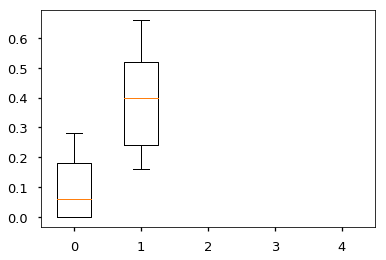

Subject: 142595 predicted bradykinesia vs actual bradykinesia



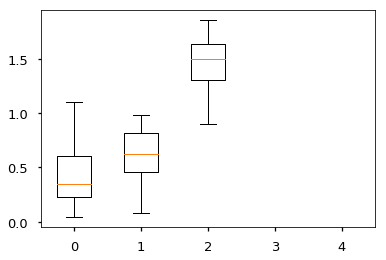

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142583
mean squared error tremor: 0.043479134199134205
corr coef tremor predicted vs known: 0.5648685707713886
mean squared error bradykinesia: 0.43145489177489177
corr coef bradykinesia predicted vs known: 0.6943096747837753


Subject: 142583 predicted tremor vs actual tremor



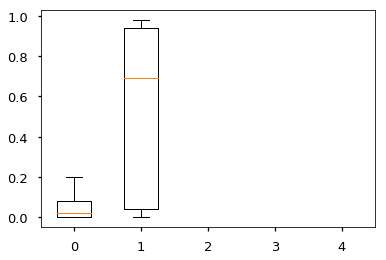

Subject: 142583 predicted bradykinesia vs actual bradykinesia



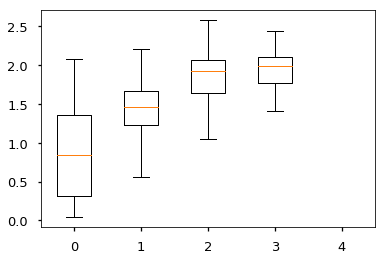

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142577
mean squared error tremor: 1.9110768496420045
corr coef tremor predicted vs known: 0.09191847658621505
mean squared error bradykinesia: 0.10292458233890214
corr coef bradykinesia predicted vs known: 0.03304317862026349


Subject: 142577 predicted tremor vs actual tremor



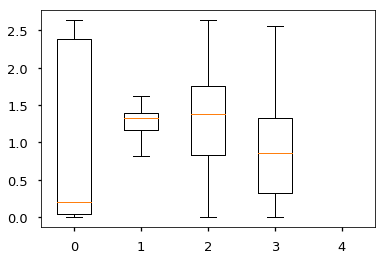

Subject: 142577 predicted bradykinesia vs actual bradykinesia



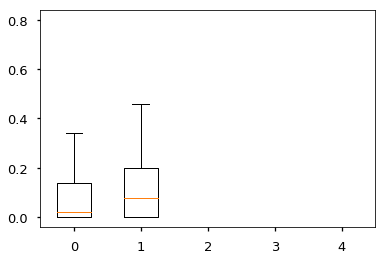

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142622
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.30563902439024393
corr coef bradykinesia predicted vs known: 0.4737106575445459


Subject: 142622 predicted tremor vs actual tremor



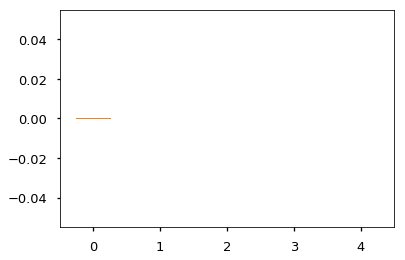

Subject: 142622 predicted bradykinesia vs actual bradykinesia



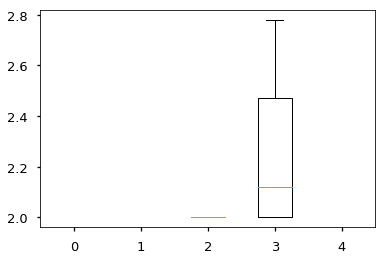

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142612
mean squared error tremor: 0.35229923664122137
corr coef tremor predicted vs known: 0.5367909392588116
mean squared error bradykinesia: 0.0
corr coef bradykinesia predicted vs known: nan


Subject: 142612 predicted tremor vs actual tremor



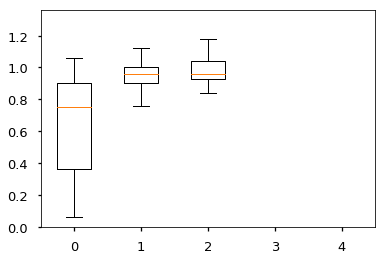

Subject: 142612 predicted bradykinesia vs actual bradykinesia



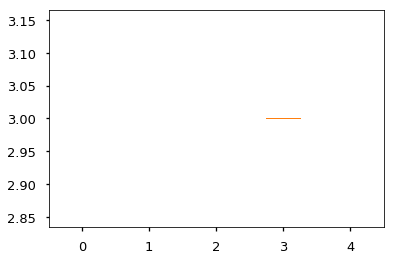

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142575
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.059889781859931115
corr coef bradykinesia predicted vs known: 0.1710260955951848


Subject: 142575 predicted tremor vs actual tremor



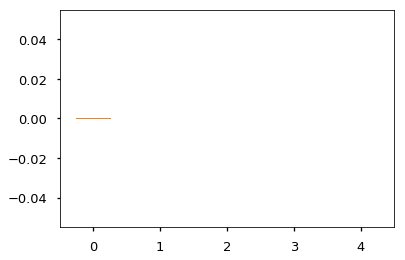

Subject: 142575 predicted bradykinesia vs actual bradykinesia



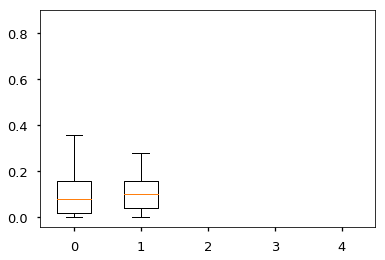

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142585
mean squared error tremor: 0.31700971867007677
corr coef tremor predicted vs known: 0.7647973033152504
mean squared error bradykinesia: 0.3369130434782609
corr coef bradykinesia predicted vs known: 0.6900278089496525


Subject: 142585 predicted tremor vs actual tremor



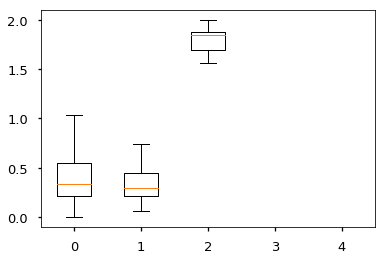

Subject: 142585 predicted bradykinesia vs actual bradykinesia



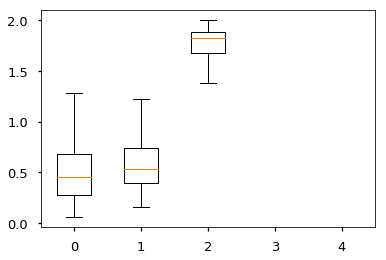

Subject: 142608
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.6790399999999999
corr coef bradykinesia predicted vs known: 0.21590743873115512


Subject: 142608 predicted tremor vs actual tremor



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


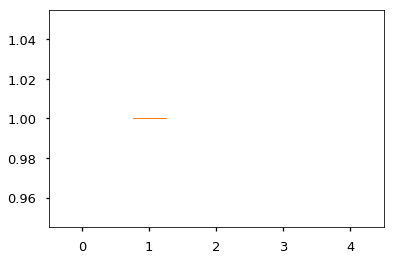

Subject: 142608 predicted bradykinesia vs actual bradykinesia



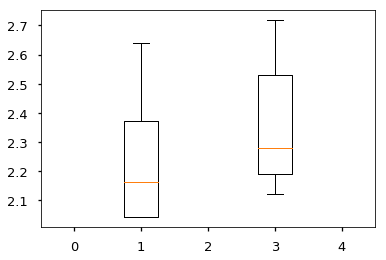

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142578
mean squared error tremor: 0.8378055222088836
corr coef tremor predicted vs known: 0.10348617327122389
mean squared error bradykinesia: 0.2588744297719088
corr coef bradykinesia predicted vs known: 0.33463250325448557


Subject: 142578 predicted tremor vs actual tremor



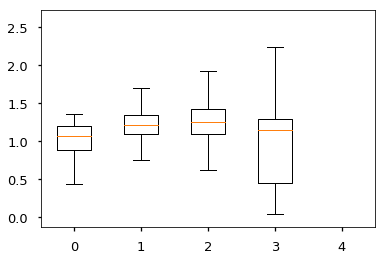

Subject: 142578 predicted bradykinesia vs actual bradykinesia



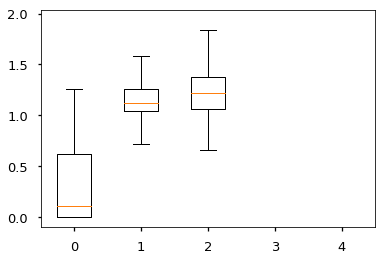

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142584
mean squared error tremor: 0.11378931677018635
corr coef tremor predicted vs known: 0.19537474818280706
mean squared error bradykinesia: 0.24264844720496895
corr coef bradykinesia predicted vs known: 0.5149556588068798


Subject: 142584 predicted tremor vs actual tremor



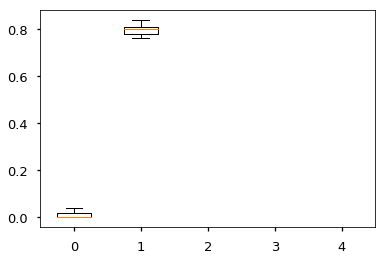

Subject: 142584 predicted bradykinesia vs actual bradykinesia



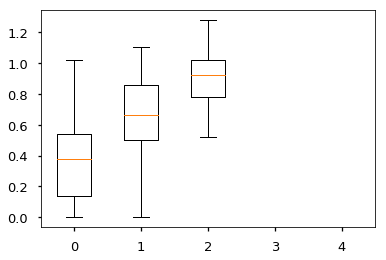

In [40]:
# general set up
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])

subjs = []
task_feature_files = os.listdir('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//')

for file in task_feature_files:
    s = int(file[0:6])
    if s not in subjs:
        subjs.append(s)
        
subj_file_dict = {key: [] for key in subjs}
        
for file in task_feature_files:
    s = int(file[0:6])
    subj_file_dict[s].append(file)
    

# get all data and remove useless rows
Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Xtrain = Xtrain[Xtrain.Subject!=1020]
Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]
Xtrain = Xtrain.reset_index(drop=True)
Dataorig = Xtrain
subjs = Xtrain.Subject.unique()
for s in subjs:
    s6 = user_id_4_to_6(s)
    
    # SETUP TRAINING DATA
    Xtrain = Dataorig.loc[Dataorig.Subject == s]
    # Xtrain = Xtrain.loc[(Xtrain.Task == 'Wlkg') | (Xtrain.Task == 'WlkgCnt')]
    # get tremor training target
    # indp = ((Xtrain['Tremor']>0))
    indp = Xtrain['Tremor']
    indp = indp.values
    ytrain_tremor = indp.astype(int)
    # get bradykinesia training target
    # indp = ((Xtrain['Bradykinesia']>0))
    indp = Xtrain['Bradykinesia']
    indp = indp.values
    ytrain_bradykinesia = indp.astype(int)
    # get the training data set
    Xtrain = Xtrain.iloc[:,5:].as_matrix()
    
    # SETUP TEST DATA
    files = subj_file_dict[s6]
    Data = pd.DataFrame()
    for f in files:
        Data = Data.append(pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + f), ignore_index = True)
    Data = Data[~Data['Tremor'].isnull()]
    Data = Data[~Data['Bradykinesia'].isnull()]
    # Data = Data[(Data.Task == 'Wlkg') | (Data.Task == 'WlkgCnt')]
    if (Data.empty):
        continue
    Xtest = Data
    ytest_tremor = Xtest['Tremor'].values
    ytest_bradykinesia = Xtest['Bradykinesia'].values
    Xtest = Xtest.iloc[:, 0:-6].as_matrix()
    
    # CREATE MODEL AND COMPARE RESULTS
    clf = RandomForestRegressor(n_estimators=50,random_state=2)
    
    clf.fit(Xtrain, ytrain_tremor)
    ypred_t = clf.predict(Xtest)
    # ypred_t = [int(round(y, 0)) for y in ypred_t]
    t_error = []
    for i in range(len(ypred_t)):
        t_error.append(math.pow(ytest_tremor[i] - ypred_t[i], 2))
    mean_squared_error_t = np.mean(t_error)
    corr_t = np.corrcoef(ytest_tremor, ypred_t)[0][1]
    
    clf.fit(Xtrain, ytrain_bradykinesia)
    ypred_b = clf.predict(Xtest)
    # ypred_b = [int(round(y, 0)) for y in ypred_b]
    b_error = []
    for i in range(len(ypred_b)):
        b_error.append(math.pow(ytest_bradykinesia[i] - ypred_b[i], 2))
    mean_squared_error_b = np.mean(b_error)
    corr_b = np.corrcoef(ytest_bradykinesia, ypred_b)[0][1]
    
    print("Subject: " + s6.__str__() + "\nmean squared error tremor: " + mean_squared_error_t.__str__() + 
          "\ncorr coef tremor predicted vs known: " + corr_t.__str__() +
          "\nmean squared error bradykinesia: " + mean_squared_error_b.__str__() + 
          "\ncorr coef bradykinesia predicted vs known: " + corr_b.__str__() + "\n\n")
    # print distributions of predicted scores vs actual scores
    t_predictions = [[],[],[],[],[]]
    b_predictions = [[],[],[],[],[]]
    for i in range(len(ypred_b)):
        t = int(ytest_tremor[i])
        b = int(ytest_bradykinesia[i])
        t_predictions[t].append(ypred_t[i])
        b_predictions[b].append(ypred_b[i])

    print('Subject: ' + s6.__str__() + ' predicted tremor vs actual tremor\n')
    plt.boxplot(x = t_predictions, labels = ['0', '1', '2', '3', '4'])
    plt.show()
    print('Subject: ' + s6.__str__() + ' predicted bradykinesia vs actual bradykinesia\n')
    plt.boxplot(x = b_predictions, labels = ['0', '1', '2', '3', '4'])
    plt.show()

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Use Personal Models on Home Data, look at Correlations with MDS Scores

In [41]:
# general set up
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])

home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features + Gait/')
for name in home_feature_files:
    if "features" not in name:
        home_feature_files.remove(name)
        
test_set_info_cols = ['subj', 'date', 'MDS score']
    
# get all data and remove useless rows
Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Xtrain = Xtrain[Xtrain.Subject!=1020]
Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]
Xtrain = Xtrain.reset_index(drop=True)
Dataorig = Xtrain
subjs = Xtrain.Subject.unique()

results = pd.DataFrame()
for s in subjs:
    s6 = user_id_4_to_6(s)
    
    # SETUP TRAINING DATA
    Xtrain = Dataorig.loc[Dataorig.Subject == s]
    Xtrain = Xtrain.loc[(Xtrain.Task == 'Wlkg')] # | (Xtrain.Task == 'WlkgCnt')] # optional walking only data
    # get tremor training target
    # indp = ((Xtrain['Tremor']>0))
    indp = Xtrain['Tremor']
    indp = indp.values
    ytrain_tremor = indp.astype(int)
    # get bradykinesia training target
    # indp = ((Xtrain['Bradykinesia']>0))
    indp = Xtrain['Bradykinesia']
    indp = indp.values
    ytrain_bradykinesia = indp.astype(int)
    # get the training data set
    if (Xtrain.empty):
        continue
    Xtrain = Xtrain.iloc[:,5:].as_matrix()
    
    # SETUP TESTING DATA
    files_to_examine = [file for file in home_feature_files if s6.__str__() in file]
    Xtest_sets = []
    test_set_info = []
    if (len(files_to_examine) == 0):
        print('no files for ' + s6.__str__())
        continue
    for file in files_to_examine:
        user = int(file[14:20])
        date = dt.datetime.strptime(file[21:31], "%Y-%m-%d")
        try:
            MDS_score = int(summary_info.loc[(summary_info.FormDate == date) & (summary_info["6_digit_id"] == user), 'MDS_score'])
        except:
            MDS_score = float('Nan')
            continue
        Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features + Gait//' + file)
        Xtest = Xtest.loc[Xtest.Gait != 0] # optional walking only data
        Xtest = Xtest.iloc[:, 2:-3]
        num_clips = len(Xtest.index)
        if(num_clips == 0):
            continue
        test_set_info.append([user, date, MDS_score])
        if (Xtest.empty):
            continue
        Xtest_sets.append(Xtest.as_matrix())
    ### RUN TRAINING ALGORITHM ###
    if (len(test_set_info) == 0):
        continue
    
    df = train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols)
    results = results.append(df, ignore_index = True)
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packag

In [42]:
correlations = results.corr(method = 'pearson')
display(correlations)

,subj,MDS score,tremor score,ts_var,bradykinesia score,bs_var
subj,1.000000,0.000861,0.019325,-0.276990,0.632404,-0.251454
MDS score,0.000861,1.000000,0.271524,0.223491,-0.008382,-0.384924
tremor score,0.019325,0.271524,1.000000,0.025279,0.571938,-0.179047
ts_var,-0.276990,0.223491,0.025279,1.000000,-0.008072,-0.048762
bradykinesia score,0.632404,-0.008382,0.571938,-0.008072,1.000000,-0.151862
bs_var,-0.251454,-0.384924,-0.179047,-0.048762,-0.151862,1.000000


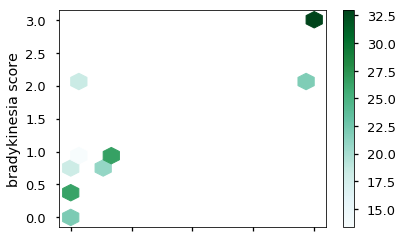

In [43]:
# bradykinesia score vs tremor score where color indicates MDS score
results.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', gridsize = 15, reduce_C_function = np.mean)
plt.show()

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Plot Error for Each Subject on Model Trained on All Clinic Data

In [44]:
### SETUP TRAINING DATA (from clicic visits) ###
# optional exclude subjects with poor correlation 
s6_to_exclude = [142578, 142577, 142561, 142563, 142612, 142608]
s4_to_exclude = [1049, 1038, 1005, 1009, 1043, 1048]

warnings.filterwarnings("ignore")

# get all data and remove useless rows
Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Xtrain = Xtrain[Xtrain.Subject!=1020]
Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]
# Xtrain = Xtrain[~Xtrain['Subject'].isin(s6_to_exclude)] # optional exclude, see above
Xtrain = Xtrain.reset_index(drop=True)
# get tremor training target
# indp = ((Xtrain['Tremor']>0))
indp = Xtrain['Tremor']
indp = indp.values
ytrain_tremor = indp.astype(int)
# get bradykinesia training target
# indp = ((Xtrain['Bradykinesia']>0))
indp = Xtrain['Bradykinesia']
indp = indp.values
ytrain_bradykinesia = indp.astype(int)
# get the training data set
Xtrain = Xtrain.iloc[:,5:].as_matrix()

In [45]:
## SET UP TEST DATA ###

# get all data
Xtest_sets = []
test_set_info_cols = ['subj', 'date', 'actual_t', 'actual_b']

task_feature_files = os.listdir('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//')

summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study//subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# get the testing data sets and the summary info about each testing set
subjs = []
for file in task_feature_files:
    user = file[0:6]
    if (user == '142592'):
        continue
    # if(int(user) in s6_to_exclude): # optional exclude subjects with poor correlation, see explanation above
    #     continue
    if user not in subjs:
        subjs.append(user)
mse_t = [float('nan') for s in subjs]
mse_b = [float('nan') for s in subjs]
num_samples = [float('nan') for s in subjs]
for s in subjs:
    print(s)
    feature_files_to_examine = [file for file in task_feature_files if s in file]
    test_set_info = []
    Xtest_sets = []
    i = subjs.index(s)
    
    for file in feature_files_to_examine:
        user = int(file[0:6])
        date = dt.datetime.strptime(file[7:17], "%Y-%m-%d")
        trial = int(file[-5:-4])
        task = file[18:-6]
        Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + file)
        Xtest = Xtest[~Xtest['Tremor'].isnull()]
        Xtest = Xtest[~Xtest['Bradykinesia'].isnull()]
        if(Xtest.empty):
            continue
        actual_t = np.nanmean(Xtest['Tremor'].values)
        actual_b = np.nanmean(Xtest['Bradykinesia'].values)
        Xtest = Xtest.iloc[:, 0:-6]
        test_set_info.append([user, date, actual_t, actual_b])
        Xtest_sets.append(Xtest.as_matrix())
    ### RUN TRAINING ALGORITHM ###
    df = train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols)
    y_pred_t = np.array(df['tremor score'].values)
    y_pred_b = np.array(df['bradykinesia score'].values)
    y_act_t = np.array(df['actual_t'].values)
    y_act_b = np.array(df['actual_b'].values)
    mse_t[i] = float(np.mean((y_act_t - y_pred_t)**2))
    mse_b[i] = float(np.mean((y_act_b - y_pred_b)**2))
    num_samples[i] = len(y_pred_t)
   

142581
142560
142594
142583
142618
142622
142584
142575
142577
142582
142580
142612
142563
142593
142579
142578
142595
142562
142585
142608
142561


(0, 3.25)

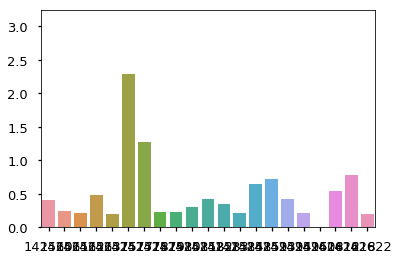

In [46]:
# plot tremor data
sns.barplot(x = subjs, y = mse_t)
plt.ylim([0,3.25])

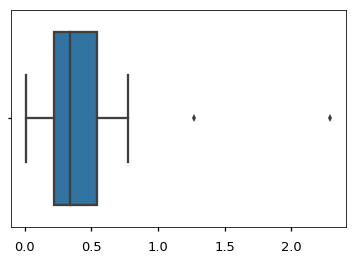

<Figure size 432x288 with 0 Axes>

In [47]:
# box plot of mse_t values
sns.boxplot(mse_t)
plt.figure()
plt.show()

In [48]:
# correlation between error in tremor score and the number of samples tested
print(np.corrcoef(num_samples, mse_t))

[[1.         0.19058526]
 [0.19058526 1.        ]]


(0, 3.25)

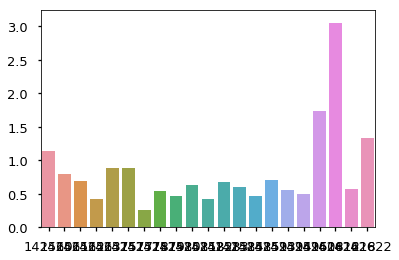

In [49]:
# plot bradykinesia data
sns.barplot(x = subjs, y = mse_b)
plt.ylim([0,3.25])

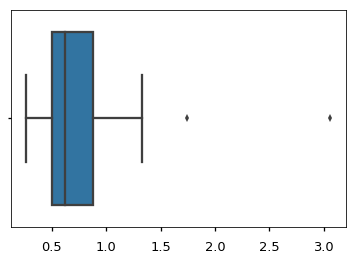

<Figure size 432x288 with 0 Axes>

In [50]:
# box plot of mse_b values
sns.boxplot(mse_b)
plt.figure()
plt.show()

In [51]:
# correlation between the error in the bradykinesia score and the number of samples tested
print(np.corrcoef(num_samples, mse_b))

[[ 1.         -0.49297528]
 [-0.49297528  1.        ]]


In [52]:
for i in range(len(subjs)):
    print(subjs[i].__str__() + "    " + mse_t[i].__str__() + "    " + mse_b[i].__str__() + "\n")


142581    0.30369724255022407    0.6239923848378681

142560    0.4085610645989957    1.134556766805154

142594    0.42227112692747115    0.5600250555568154

142583    0.3418484241607886    0.6815803640142155

142618    0.7728974471926813    0.5673549263435671

142622    0.2041408219797614    1.326726808248692

142584    0.21200334165347462    0.5970622276764016

142575    0.1964309655393357    0.8811007775610195

142577    2.2928528686360976    0.8907408668175768

142582    0.4208377555012142    0.42533674144085337

142580    0.225999565227647    0.4593369503631644

142612    0.541983983800829    3.059506500433005

142563    0.4757070967098533    0.4254539191037257

142593    0.7234687849861239    0.7081948509845187

142579    0.22966337609345058    0.5419459352515518

142578    1.2666233395912625    0.26361598982736034

142595    0.2159217421138826    0.5006399021237551

142562    0.21340386177885604    0.6941599711560563

142585    0.6503751102214648    0.47242179721900046

142608   

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Train Model on Clinic Data and Test on Home Data , Leave out poor fitting subjects, Walking Only

In [53]:
### SETUP TRAINING DATA (from clicic visits) ###
s6_to_exclude = [142578, 142577, 142561, 142563, 142612, 142608]
s4_to_exclude = [1049, 1038, 1005, 1009, 1043, 1048]

# get all data and remove useless rows
Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Xtrain = Xtrain[Xtrain.Subject!=1020]
Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]

Xtrain = Xtrain[~Xtrain.Subject.isin(s6_to_exclude)]
Xtrain = Xtrain[~Xtrain.Subject.isin(s4_to_exclude)]

Xtrain = Xtrain.reset_index(drop=True)
# get tremor training target
# indp = ((Xtrain['Tremor']>0))
indp = Xtrain['Tremor']
indp = indp.values
ytrain_tremor = indp.astype(int)
# get bradykinesia training target
# indp = ((Xtrain['Bradykinesia']>0))
indp = Xtrain['Bradykinesia']
indp = indp.values
ytrain_bradykinesia = indp.astype(int)
# get the training data set
Xtrain = Xtrain.iloc[:,5:].as_matrix()

In [54]:
### SET UP TEST DATA - Walking Only ###
# get all data
Xtest_sets = []
test_set_info = []
test_set_info_cols = ['subj', 'date', 'MDS score']

home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features + Gait/')
for name in home_feature_files:
    if "features" not in name:
        home_feature_files.remove(name)
summary_info = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study\\subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# get the testing data sets and the summary info about each testing set
for file in home_feature_files:
    user = int(file[14:20])
    if user in s6_to_exclude:
        continue
    date = dt.datetime.strptime(file[21:31], "%Y-%m-%d")
    trial = int(file[21:22])
    try:
        MDS_score = int(summary_info.loc[(summary_info.trial == trial) & (summary_info["6_digit_id"] == user), 'MDS_score'])
    except:
        MDS_score = float('Nan')
    Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features + Gait//' + file)
    Xtest = Xtest.loc[Xtest.Gait != 0]
    Xtest = Xtest.iloc[:, 2:-3]
    num_clips = len(Xtest.index)
    if(num_clips == 0):
        continue
    test_set_info.append([user, date, MDS_score])
    Xtest_sets.append(Xtest.as_matrix())

In [55]:
### RUN TRAINING ALGORITHM ###
df = train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols)
correlations = df.corr(method = 'pearson')
correlations.style

,subj,MDS score,tremor score,ts_var,bradykinesia score,bs_var
subj,1,-0.176464,0.115636,0.15987,-0.0341678,0.116669
MDS score,-0.176464,1,0.51107,0.348992,-0.196418,0.17059
tremor score,0.115636,0.51107,1,0.784716,-0.210816,0.461092
ts_var,0.15987,0.348992,0.784716,1,-0.0798382,0.417217
bradykinesia score,-0.0341678,-0.196418,-0.210816,-0.0798382,1,-0.55288
bs_var,0.116669,0.17059,0.461092,0.417217,-0.55288,1


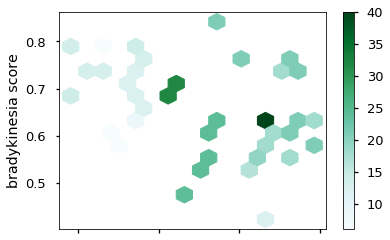

In [56]:
df.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', gridsize = 15, reduce_C_function = np.mean)

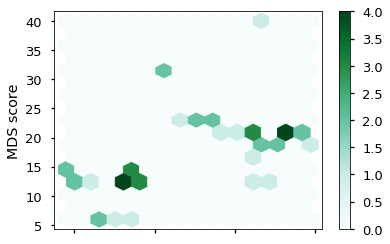

In [57]:
df.plot.hexbin(x = 'tremor score', y = 'MDS score', gridsize = 15)

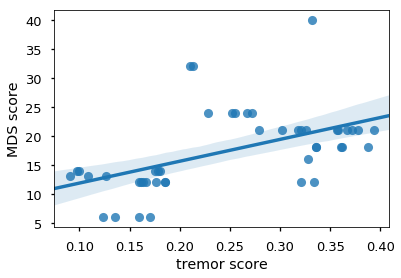

In [58]:
sns.regplot(x = 'tremor score', y = 'MDS score', data = df[['tremor score', 'MDS score']], order = 1)

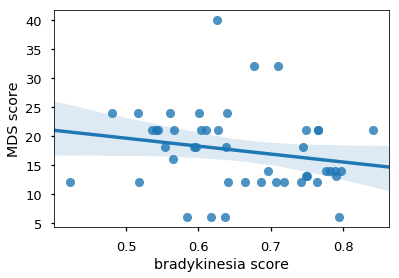

In [59]:
sns.regplot(x = 'bradykinesia score', y = 'MDS score', data = df[['bradykinesia score', 'MDS score']], order = 1)

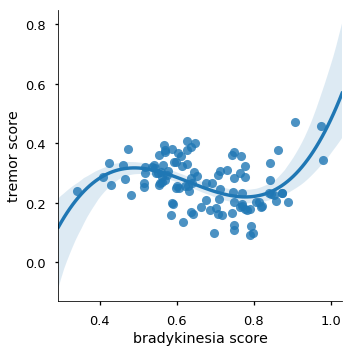

In [60]:
sns.lmplot(x = 'bradykinesia score', y = 'tremor score', data = df[['bradykinesia score', 'tremor score']], order = 3)